## DC2 Cataloging Experiments

### Prepare Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import sklearn
import sklearn.metrics

from hydra import initialize, compose
from hydra.utils import instantiate
from typing import List, Dict
from pathlib import Path
from pytorch_lightning.utilities import move_data_to_device
from astropy.visualization import make_lupton_rgb

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog, FullCatalog
from bliss.encoder.encoder import Encoder
from bliss.encoder.metrics import SourceTypeAccuracy, CatalogMatcher, DetectionPerformance, SourceTypeFilter

from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.dc2_cataloging.utils.bootstrap_tile_cat import bootstrap_tile_cat
from case_studies.dc2_cataloging.utils.lsst_predictor import LSSTPredictor
from case_studies.dc2_cataloging.utils.notebook_plotting_params import NoteBookPlottingParams
from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.others import move_tile_cat_to_device
from case_studies.dc2_cataloging.utils.metrics import (
    DetectionRecallwrtBlendedness, 
    EllipticityResidual, 
    EllipticityResidualwrtBlendedness, 
    InBoundaryFilter, 
    OutBoundaryFilter
)


# set path
output_dir = Path("./plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_name = "exp_08-06-1"
model_path = f"../../../bliss_output/DC2_cataloging_exp/{model_name}/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

# set device
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

# load config
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

# get matcher and set metric parameters
matcher: CatalogMatcher = instantiate(notebook_cfg.encoder.matcher)
bs_epochs_num = 30
base_flux_bin_cutoffs = [200, 400, 600, 800, 1000]
mag_zero_point = 3631e9
blendedness_bin_cutoffs = [0.001, 0.02, 0.1, 0.2, 0.6]
bands = ("u", "g", "r", "i", "z", "y")
tile_slen = notebook_cfg.surveys.dc2.tile_slen
boundary_width = 0.2  # for boundary performance


### Inference

In [3]:
inference_output_dir = Path("/data/scratch/pduan/notebook_output/inference/")  # don't have enough space under home directory
inference_output_dir.mkdir(exist_ok=True)

#### On One 4000 x 4000 Image

In [4]:
test_4000x4000_results_file = inference_output_dir / f"{model_name}_test_4000x4000_results.pkl"

In [5]:
class Test4000x4000Results:
    def __init__(self, 
                 test_image_idx: int,
                 test_image: torch.Tensor, 
                 image_lim: int,
                 test_image_full_cat: FullCatalog,
                 bliss_full_cat: FullCatalog,
                 lsst_full_cat: FullCatalog):
        self.test_image_idx = test_image_idx
        self.test_image = test_image
        self.image_lim = image_lim
        self.test_image_full_cat = test_image_full_cat
        self.bliss_full_cat = bliss_full_cat
        self.lsst_full_cat = lsst_full_cat

In [6]:
def inference_for_4000x4000_image(test_image_idx: int):
    test_image, test_image_full_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                                                test_image_idx, 
                                                                                model_path, 
                                                                                lsst_root_dir, 
                                                                                device)
    image_lim = test_image.shape[1]
    return Test4000x4000Results(test_image_idx,
                                test_image,
                                image_lim,
                                test_image_full_cat,
                                bliss_full_cat,
                                lsst_full_cat)

In [7]:
if not test_4000x4000_results_file.exists():
    print(f"can't find {test_4000x4000_results_file}, and try to genrate it", flush=True)
    test_4000x4000_results = inference_for_4000x4000_image(test_image_idx=0)
    with open(test_4000x4000_results_file, "wb") as f:
        pickle.dump(test_4000x4000_results, f, pickle.HIGHEST_PROTOCOL)
else:
    print(f"find {test_4000x4000_results_file}, and directly use it", flush=True)
    with open(test_4000x4000_results_file, "rb") as f:
        test_4000x4000_results = pickle.load(f)

find /data/scratch/pduan/notebook_output/inference/exp_08-06-1_test_4000x4000_results.pkl, and directly use it


#### On Batched Images

In [8]:
batched_inference_results_file = inference_output_dir / f"{model_name}_batched_inference_results.pkl"

In [9]:
class BatchedInferenceResults:
    def __init__(self, 
                 bliss_tile_cat_list: List[TileCatalog],
                 lsst_tile_cat_list: List[TileCatalog],
                 target_tile_cat_list: List[TileCatalog]):
        self.bliss_tile_cat_list = bliss_tile_cat_list
        self.lsst_tile_cat_list = lsst_tile_cat_list
        self.target_tile_cat_list = target_tile_cat_list
    
    def __iter__(self):
        return zip(self.bliss_tile_cat_list,
                   self.lsst_tile_cat_list,
                   self.target_tile_cat_list,
                   strict=True)

In [10]:
def inference_for_batched_images():
    # setup bliss encoder
    tile_slen = notebook_cfg.surveys.dc2.tile_slen
    max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
    r_band_min_flux = notebook_cfg.notebook_var.r_band_min_flux
    
    dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
    dc2.setup(stage="validate")
    dc2_val_dataloader = dc2.val_dataloader()

    bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
    pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
    bliss_encoder.load_state_dict(pretrained_weights)
    bliss_encoder = bliss_encoder.eval()

    # setup lsst encoder
    lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile)

    bliss_tile_cat_list = []
    lsst_tile_cat_list = []
    target_tile_cat_list = []
    for batch in tqdm.tqdm(dc2_val_dataloader):
        batch_on_device = move_data_to_device(batch, device=device)
        target_tile_cat = TileCatalog(batch["tile_catalog"])
        target_tile_cat = target_tile_cat.filter_by_flux(
                min_flux=r_band_min_flux,
                band=2,  # default is r band
            )
        with torch.no_grad():
            bliss_tile_cat = bliss_encoder.sample(batch_on_device, use_mode=True)
            bliss_tile_cat = bliss_tile_cat.filter_by_flux(
                min_flux=r_band_min_flux,
                band=2,
            )
        target_tile_cat_list.append(move_tile_cat_to_device(target_tile_cat, device="cpu"))
        bliss_tile_cat_list.append(move_tile_cat_to_device(bliss_tile_cat, device="cpu"))
        
        wcs_header_str_list = batch["wcs_header_str"]
        image_lim = batch["images"].shape[2]
        height_index_list = batch["image_height_index"].tolist()
        width_index_list = batch["image_width_index"].tolist()
        lsst_tile_cat = lsst_predictor.predict(wcs_header_str_list, 
                                                image_lim, 
                                                height_index_list, 
                                                width_index_list)
        lsst_tile_cat_list.append(lsst_tile_cat)
    
    return BatchedInferenceResults(bliss_tile_cat_list,
                                    lsst_tile_cat_list,
                                    target_tile_cat_list)

In [11]:
if not batched_inference_results_file.exists():
    print(f"can't find {batched_inference_results_file}, and try to generate it", flush=True)
    batched_inference_results = inference_for_batched_images()
    with open(batched_inference_results_file, "wb") as f:
        pickle.dump(batched_inference_results, f, pickle.HIGHEST_PROTOCOL)
else:
    print(f"find {batched_inference_results_file}, and directly use it", flush=True)
    with open(batched_inference_results_file, "rb") as f:
        batched_inference_results = pickle.load(f)

find /data/scratch/pduan/notebook_output/inference/exp_08-06-1_batched_inference_results.pkl, and directly use it


#### Bootstrap

In [12]:
bs_results_file = inference_output_dir / f"{model_name}_bs_results.pkl"

In [13]:
class BSResults:
    def __init__(self, 
                 bs_epochs_num: int,
                 bliss_full_cat_bs_list: List[List[FullCatalog]],
                 lsst_full_cat_bs_list: List[List[FullCatalog]],
                 target_full_cat_bs_list: List[List[FullCatalog]],
                 bliss_matching_bs_list: List[List[torch.Tensor]],
                 lsst_matching_bs_list: List[List[torch.Tensor]]):
        self.bs_epochs_num = bs_epochs_num
        self.bliss_full_cat_bs_list = bliss_full_cat_bs_list
        self.lsst_full_cat_bs_list = lsst_full_cat_bs_list
        self.target_full_cat_bs_list = target_full_cat_bs_list
        self.bliss_matching_bs_list = bliss_matching_bs_list
        self.lsst_matching_bs_list = lsst_matching_bs_list

    def __iter__(self):
        for epoch in range(self.bs_epochs_num):
            yield (epoch, 
                   zip(self.bliss_full_cat_bs_list[epoch],
                       self.lsst_full_cat_bs_list[epoch],
                       self.target_full_cat_bs_list[epoch],
                       self.bliss_matching_bs_list[epoch],
                       self.lsst_matching_bs_list[epoch],
                       strict=True),
                )

In [14]:
def bootstrap_inference(batched_inference_results: BatchedInferenceResults):
    tile_slen = notebook_cfg.surveys.dc2.tile_slen

    bliss_full_cat_bs_list = []
    lsst_full_cat_bs_list = []
    target_full_cat_bs_list = []
    bliss_matching_bs_list = []
    lsst_matching_bs_list = []

    for epoch in range(bs_epochs_num):
        print(f"Epoch: {epoch}")
        seed = random.randint(1e4, 1e5 - 1)
        bliss_full_cat_bs_list.append([])
        lsst_full_cat_bs_list.append([])
        target_full_cat_bs_list.append([])
        bliss_matching_bs_list.append([])
        lsst_matching_bs_list.append([])
        for bliss_tile_cat, lsst_tile_cat, target_tile_cat in tqdm.tqdm(batched_inference_results):
            bliss_full_cat = bootstrap_tile_cat(bliss_tile_cat, seed=seed).to_full_catalog(tile_slen)
            lsst_full_cat = bootstrap_tile_cat(lsst_tile_cat, seed=seed).to_full_catalog(tile_slen)
            target_full_cat = bootstrap_tile_cat(target_tile_cat, seed=seed).to_full_catalog(tile_slen)
            bliss_full_cat_bs_list[epoch].append(bliss_full_cat)
            lsst_full_cat_bs_list[epoch].append(lsst_full_cat)
            target_full_cat_bs_list[epoch].append(target_full_cat)

            bliss_matching = matcher.match_catalogs(target_full_cat, bliss_full_cat)
            lsst_matching = matcher.match_catalogs(target_full_cat, lsst_full_cat)
            bliss_matching_bs_list[epoch].append(bliss_matching)
            lsst_matching_bs_list[epoch].append(lsst_matching)

    return BSResults(bs_epochs_num,
                     bliss_full_cat_bs_list,
                     lsst_full_cat_bs_list,
                     target_full_cat_bs_list,
                     bliss_matching_bs_list,
                     lsst_matching_bs_list)

In [15]:
if not bs_results_file.exists():
    print(f"can't find {bs_results_file}, and try to generate it", flush=True)
    bs_results = bootstrap_inference(batched_inference_results)
    with open(bs_results_file, "wb") as f:
        pickle.dump(bs_results, f, pickle.HIGHEST_PROTOCOL)
else:
    print(f"find {bs_results_file}, and directly use it", flush=True)
    with open(bs_results_file, "rb") as f:
        bs_results = pickle.load(f)

find /data/scratch/pduan/notebook_output/inference/exp_08-06-1_bs_results.pkl, and directly use it


### Show Detections

#### On One 4000x4000 Image

In [16]:
detection_output_dir = output_dir / "detections"
detection_output_dir.mkdir(exist_ok=True)

In [17]:
class DetectionPlotting:
    def __init__(self, 
                 test_image_full_cat: FullCatalog,
                 bliss_full_cat: FullCatalog,
                 lsst_full_cat: FullCatalog,
                 image: torch.Tensor,
                 image_lim: int,
                 sub_image_len: int,
                 threshold: float,
                 first_legend_h_ploc: int,
                 first_legend_w_ploc: int):
        self.test_image_full_cat = test_image_full_cat
        self.bliss_full_cat = bliss_full_cat
        self.lsst_full_cat = lsst_full_cat
        assert self.test_image_full_cat["n_sources"].shape[0] == 1
        assert self.bliss_full_cat["n_sources"].shape[0] == 1
        assert self.lsst_full_cat["n_sources"].shape[0] == 1
        self.image = image
        self.image_lim = image_lim
        self.sub_image_len = sub_image_len
        self.threshold = threshold
        self.first_legend_h_ploc = first_legend_h_ploc
        self.first_legend_w_ploc = first_legend_w_ploc

    def plot(self):
        for i in range(0, self.image_lim, self.sub_image_len):
            for j in range(0, self.image_lim, self.sub_image_len):
                plocs_box_origin = torch.tensor([i, j])

                cur_target_full_cat = self.test_image_full_cat.filter_by_ploc_box(plocs_box_origin, self.sub_image_len)
                cur_bliss_full_cat = self.bliss_full_cat.filter_by_ploc_box(plocs_box_origin, self.sub_image_len)
                cur_lsst_full_cat = self.lsst_full_cat.filter_by_ploc_box(plocs_box_origin, self.sub_image_len)
                bliss_matching = matcher.match_catalogs(cur_target_full_cat, cur_bliss_full_cat)[0]  # batch size == 1
                lsst_matching = matcher.match_catalogs(cur_target_full_cat, cur_lsst_full_cat)[0]
                
                n_bliss_matching = len(bliss_matching[1])
                n_lsst_matching = len(lsst_matching[1])
                n_target = cur_target_full_cat["plocs"].shape[1]
                bliss_lsst_matching_diff = abs(n_bliss_matching - n_lsst_matching) / n_target if n_target != 0 else 0
                if bliss_lsst_matching_diff < self.threshold:
                    continue

                target_set = set(list(range(0, cur_target_full_cat["plocs"].shape[1])))
                bliss_match_set = set(bliss_matching[0].int().tolist())
                lsst_match_set = set(lsst_matching[0].int().tolist())

                missing_match = list(target_set - (bliss_match_set | lsst_match_set))
                only_bliss_match = list(bliss_match_set - lsst_match_set)
                only_lsst_match = list(lsst_match_set - bliss_match_set)
                both_match = list(lsst_match_set & bliss_match_set)

                bliss_target_set = set(list(range(0, cur_bliss_full_cat["plocs"].shape[1])))
                lsst_target_set = set(list(range(0, cur_lsst_full_cat["plocs"].shape[1])))
                bliss_match_set = set(bliss_matching[1].int().tolist())
                lsst_match_set = set(lsst_matching[1].int().tolist())
                bliss_error = list(bliss_target_set - bliss_match_set)
                lsst_error = list(lsst_target_set - lsst_match_set)

                fig, ax = plt.subplots(figsize=NoteBookPlottingParams.figsize)
                image_sub = self.image[:, i:(i + self.sub_image_len), j:(j + self.sub_image_len)]
                # image_sub_dict = {b: image_sub[bi].numpy() for bi, b in enumerate(bands)}
                # lo_val, up_val = np.percentile(np.hstack((image_sub_dict["r"].flatten(), 
                #                                           image_sub_dict["g"].flatten(), 
                #                                           image_sub_dict["u"].flatten())), (0.5, 99.5))
                # stretch_val = up_val - lo_val
                # image_sub = make_lupton_rgb(image_sub_dict["i"], image_sub_dict["r"], image_sub_dict["g"])
                image_sub_one = ((image_sub + 0.5).norm(dim=0, p=1) / len(bands)).clamp(min=0, max=1)
                image_sub_one = (image_sub_one * 255).clamp(min=0, max=255)
                ax.imshow(image_sub_one, cmap="gray", vmin=0, vmax=255)
                ax.scatter(cur_target_full_cat["plocs"][0, only_bliss_match, 1], 
                           cur_target_full_cat["plocs"][0, only_bliss_match, 0], 
                           facecolors="none", edgecolors=NoteBookPlottingParams.color_dict["detection_plot"]["only_bliss"], 
                           alpha=1, s=80, linewidth=2, label="Only BLISS")
                ax.scatter(cur_target_full_cat["plocs"][0, only_lsst_match, 1], 
                          cur_target_full_cat["plocs"][0, only_lsst_match, 0], 
                          facecolors="none", edgecolors=NoteBookPlottingParams.color_dict["detection_plot"]["only_lsst"], 
                          alpha=1, s=80, linewidth=2, label="Only LSST")
                ax.scatter(cur_target_full_cat["plocs"][0, both_match, 1], 
                           cur_target_full_cat["plocs"][0, both_match, 0], 
                           facecolors="none", edgecolors=NoteBookPlottingParams.color_dict["detection_plot"]["both"], 
                           alpha=1, s=80, linewidth=2, label="Both")
                ax.scatter(cur_target_full_cat["plocs"][0, missing_match, 1], 
                           cur_target_full_cat["plocs"][0, missing_match, 0], 
                           facecolors="none", edgecolors=NoteBookPlottingParams.color_dict["detection_plot"]["neither"], 
                           alpha=1, s=80, linewidth=2, label="Neither")
                ax.scatter(cur_bliss_full_cat["plocs"][0, bliss_error, 1], 
                           cur_bliss_full_cat["plocs"][0, bliss_error, 0],
                           marker="X", 
                           facecolors=NoteBookPlottingParams.color_dict["detection_plot"]["only_bliss"], 
                           edgecolors=NoteBookPlottingParams.color_dict["detection_plot"]["only_bliss"], 
                            alpha=1, s=40, linewidth=1, label="BLISS Error")
                ax.scatter(cur_lsst_full_cat["plocs"][0, lsst_error, 1], 
                           cur_lsst_full_cat["plocs"][0, lsst_error, 0],
                           marker="X", 
                           facecolors=NoteBookPlottingParams.color_dict["detection_plot"]["only_lsst"], 
                           edgecolors=NoteBookPlottingParams.color_dict["detection_plot"]["only_lsst"], 
                           alpha=1, s=40, linewidth=1, label="LSST Error")
                ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)

                if i == self.first_legend_h_ploc and j == self.first_legend_w_ploc:
                    ax.legend(loc="lower right", fontsize=NoteBookPlottingParams.fontsize, framealpha=1)
                yield i, j, fig


In [18]:
detection_plotting = DetectionPlotting(test_4000x4000_results.test_image_full_cat,
                                       test_4000x4000_results.bliss_full_cat,
                                       test_4000x4000_results.lsst_full_cat,
                                       image=test_4000x4000_results.test_image,
                                       image_lim=test_4000x4000_results.image_lim,
                                       sub_image_len=100,
                                       threshold=0.5,
                                       first_legend_h_ploc=600,
                                       first_legend_w_ploc=1800)

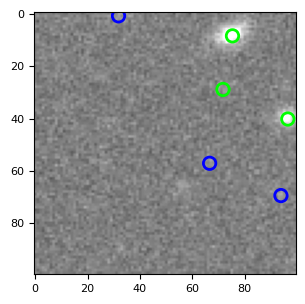

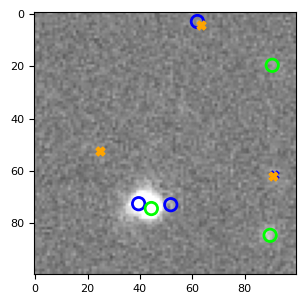

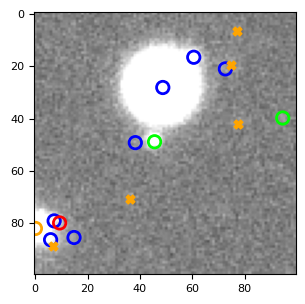

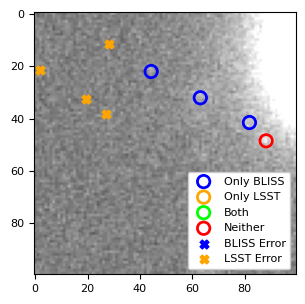

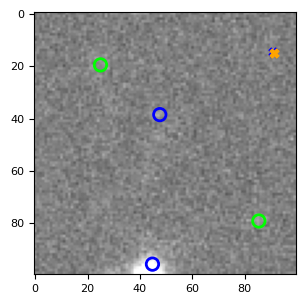

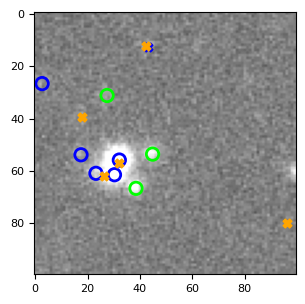

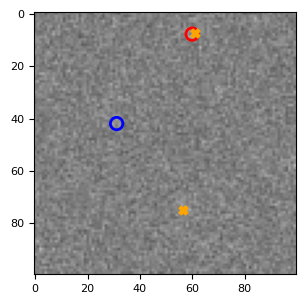

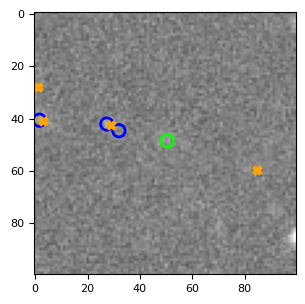

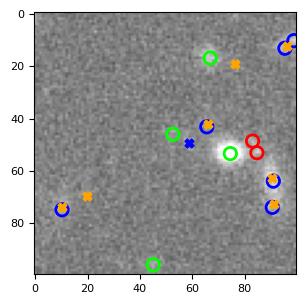

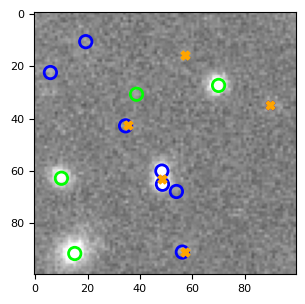

In [19]:
for i, j, fig in detection_plotting.plot():
    fig.savefig(detection_output_dir / f"image_{test_4000x4000_results.test_image_idx}_{i}_{j}.pdf", 
                bbox_inches="tight", 
                dpi=NoteBookPlottingParams.dpi)
    fig.show()

### Classification Acc

#### Bootstrap

In [20]:
classification_acc_bs_output_dir = output_dir / "classification_acc_bs"
classification_acc_bs_output_dir.mkdir(exist_ok=True)

In [164]:
class ClassificationAccBSPlotting:
    def __init__(self, 
                 bliss_metric_internal_states: Dict[str, torch.Tensor], 
                 lsst_metric_internal_states: Dict[str, torch.Tensor], 
                 bin_cutoffs: torch.Tensor):
        quantile_points = torch.tensor([0.05, 0.5, 0.95])

        self.bliss_metric_internal_states = bliss_metric_internal_states

        self.bliss_acc_matrix, self.bliss_star_acc_matrix, self.bliss_gal_acc_matrix = self.calculate_acc(
            bliss_metric_internal_states, 
            quantile_points=quantile_points
        )
        self.lsst_acc_matrix, self.lsst_star_acc_matrix, self.lsst_gal_acc_matrix = self.calculate_acc(
            lsst_metric_internal_states, 
            quantile_points=quantile_points
        )
        self.bliss_gal_f1_matrix, self.bliss_star_f1_matrix = self.calculate_f1(
            bliss_metric_internal_states, 
            quantile_points=quantile_points
        )
        self.lsst_gal_f1_matrix, self.lsst_star_f1_matrix = self.calculate_f1(
            lsst_metric_internal_states, 
            quantile_points=quantile_points
        )
        self.xlabels = (
            [f"< {bin_cutoffs[0]: .1f}"]
            + [f"[{bin_cutoffs[i]: .1f}, {bin_cutoffs[i + 1]: .1f}]" for i in range(len(bin_cutoffs) - 1)]
            + [f"> {bin_cutoffs[-1]: .1f}"]
        )


    @classmethod
    def calculate_acc(cls, metric_internal_states: Dict[str, torch.Tensor], quantile_points: Dict[str, torch.Tensor]):
        acc = ((metric_internal_states["gal_tp"] + metric_internal_states["star_tp"]) / metric_internal_states["n_matches"]).nan_to_num(0)
        star_acc = (metric_internal_states["star_tp"] / (metric_internal_states["n_matches"] - metric_internal_states["gal_tp"] - metric_internal_states["star_fp"])).nan_to_num(0)
        gal_acc = (metric_internal_states["gal_tp"] / (metric_internal_states["n_matches"] - metric_internal_states["star_tp"] - metric_internal_states["gal_fp"])).nan_to_num(0)
        acc = acc.quantile(q=quantile_points, dim=0)
        star_acc = star_acc.quantile(q=quantile_points, dim=0)
        gal_acc = gal_acc.quantile(q=quantile_points, dim=0)
        return acc, star_acc, gal_acc
    
    @classmethod
    def calculate_f1(cls, metric_internal_states: Dict[str, torch.Tensor], quantile_points: Dict[str, torch.Tensor]):
        gal_recall = metric_internal_states["gal_tp"] / (metric_internal_states["gal_tp"] + metric_internal_states["star_fp"])
        gal_precision = metric_internal_states["gal_tp"] / (metric_internal_states["gal_tp"] + metric_internal_states["gal_fp"])
        star_recall = metric_internal_states["star_tp"] / (metric_internal_states["star_tp"] + metric_internal_states["gal_fp"])
        star_precision = metric_internal_states["star_tp"] / (metric_internal_states["star_tp"] + metric_internal_states["star_fp"])
        gal_f1 = 2 * gal_precision * gal_recall / (gal_precision + gal_recall)
        star_f1 = 2 * star_precision * star_recall / (star_precision + star_recall)
        gal_f1 = gal_f1.quantile(q=quantile_points, dim=0)
        star_f1 = star_f1.quantile(q=quantile_points, dim=0)
        return gal_f1, star_f1
    
    def _plot_acc_with_state(self):
        x = np.array(list(range(len(self.xlabels))))
        bar_width = 0.4

        fig, axes = plt.subplots(
            2, 1, 
            figsize=(NoteBookPlottingParams.figsize[0], NoteBookPlottingParams.figsize[1]), 
            gridspec_kw={"height_ratios": [2, 3]}, 
            sharex="col"
        )
        axes[1].plot(
            x,
            self.bliss_acc_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label="BLISS",
        )
        axes[1].fill_between(
            x,
            self.bliss_acc_matrix[0, :],
            self.bliss_acc_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["bliss"],
            alpha=0.5,
        )
        axes[1].plot(
            x,
            self.lsst_acc_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label="LSST",
        )
        axes[1].fill_between(
            x,
            self.lsst_acc_matrix[0, :],
            self.lsst_acc_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["lsst"],
            alpha=0.5,
        )
        axes[1].set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        axes[1].set_xticks(range(len(self.xlabels)))
        axes[1].set_xticklabels(self.xlabels, rotation=45)
        axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[1].set_ylabel("Accuracy", fontsize=NoteBookPlottingParams.fontsize)
        axes[1].legend(fontsize=NoteBookPlottingParams.fontsize)
        gal_num = self.bliss_metric_internal_states["gal_tp"] + self.bliss_metric_internal_states["star_fp"]
        star_num = self.bliss_metric_internal_states["star_tp"] + self.bliss_metric_internal_states["gal_fp"]
        axes[0].bar(
            x - 0.5 * bar_width,
            star_num.mean(dim=0),
            bar_width,
            label="Star",
            color=NoteBookPlottingParams.color_dict["classification_acc_bar_plot"]["bar_colors"][1],
        )
        axes[0].bar(
            x + 0.5 * bar_width,
            gal_num.mean(dim=0),
            bar_width,
            label="Galaxy",
            color=NoteBookPlottingParams.color_dict["classification_acc_bar_plot"]["bar_colors"][2],
        )
        axes[0].set_yscale("log")
        axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[0].set_ylabel("# of objects", fontsize=NoteBookPlottingParams.fontsize)
        axes[0].legend(fontsize=NoteBookPlottingParams.fontsize)

        axes[0].grid(visible=True, axis="y")
        axes[0].grid(visible=False, axis="x")
        axes[1].grid(visible=True, axis="y")
        axes[1].grid(visible=False, axis="x")
        fig.tight_layout()

        return fig
  
    
    def _plot(self, bliss_matrix, lsst_matrix, y_axis_name):
        fig, ax = plt.subplots(1, 1, figsize=NoteBookPlottingParams.figsize)

        x = list(range(len(self.xlabels)))
        ax.plot(x, 
                bliss_matrix[1, :],
                "-o",
                color=NoteBookPlottingParams.color_dict["bliss"],
                label="BLISS")
        ax.fill_between(x,
                        bliss_matrix[0, :],
                        bliss_matrix[2, :],
                        color=NoteBookPlottingParams.color_dict["bliss"],
                        alpha=0.5)
        ax.plot(x,
                lsst_matrix[1, :],
                "-o",
                color=NoteBookPlottingParams.color_dict["lsst"],
                label="LSST")
        ax.fill_between(x,
                        lsst_matrix[0, :],
                        lsst_matrix[2, :],
                        color=NoteBookPlottingParams.color_dict["lsst"],
                        alpha=0.5)
        ax.set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        ax.set_xticks(x)
        ax.set_xticklabels(self.xlabels, rotation=45)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.set_ylabel(y_axis_name, fontsize=NoteBookPlottingParams.fontsize)
        ax.legend(fontsize=NoteBookPlottingParams.fontsize)

        ax.grid(visible=True, axis="y")
        ax.grid(visible=False, axis="x")

        fig.tight_layout()

        return fig
    
    def plot(self, plot_type: str):
        match plot_type:
            case "accuracy":
                bliss_matrix = self.bliss_acc_matrix
                lsst_matrix = self.lsst_acc_matrix
                y_axis_name = "Accuracy"
            case "accuracy_with_state":
                return self._plot_acc_with_state()
            case "star_accuracy":
                bliss_matrix = self.bliss_star_acc_matrix
                lsst_matrix = self.lsst_star_acc_matrix
                y_axis_name = "Star Accuracy"
            case "galaxy_accuracy":
                bliss_matrix = self.bliss_gal_acc_matrix
                lsst_matrix = self.lsst_gal_acc_matrix
                y_axis_name = "Galaxy Accuracy"
            case "star_f1":
                bliss_matrix = self.bliss_star_f1_matrix
                lsst_matrix = self.lsst_star_f1_matrix
                y_axis_name = "F1 (star as positive class)"
            case "galaxy_f1":
                bliss_matrix = self.bliss_gal_f1_matrix
                lsst_matrix = self.lsst_gal_f1_matrix
                y_axis_name = "F1 (galaxy as positive class)"
            case _:
                raise NotImplementedError()

        return self._plot(bliss_matrix, lsst_matrix, y_axis_name)

In [165]:
def get_classification_acc_bs_plotting():
    bliss_metrics = SourceTypeAccuracy(base_flux_bin_cutoffs=base_flux_bin_cutoffs, 
                                       mag_zero_point=mag_zero_point, 
                                       report_bin_unit="mag")
    lsst_metrics = bliss_metrics.clone()

    bliss_metrics_internal_states = {}
    lsst_metrics_internal_states = {}

    for _epoch, results in bs_results:
        for bliss_full_cat, lsst_full_cat, target_full_cat, bliss_matching, lsst_matching in results:
            bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)
            lsst_metrics.update(target_full_cat, lsst_full_cat, lsst_matching)

        metric_internal_states = bliss_metrics.get_internal_states()
        for k_state, v_state in metric_internal_states.items():
            if k_state not in bliss_metrics_internal_states:
                bliss_metrics_internal_states[k_state] = []
            bliss_metrics_internal_states[k_state].append(v_state)

        metric_internal_states = lsst_metrics.get_internal_states()
        for k_state, v_state in metric_internal_states.items():
            if k_state not in lsst_metrics_internal_states:
                lsst_metrics_internal_states[k_state] = []
            lsst_metrics_internal_states[k_state].append(v_state)

        bliss_metrics.reset()
        lsst_metrics.reset()

    bliss_metrics_internal_states = {k: torch.stack(v) for k, v in bliss_metrics_internal_states.items()}
    lsst_metrics_internal_states = {k: torch.stack(v) for k, v in lsst_metrics_internal_states.items()}

    return ClassificationAccBSPlotting(bliss_metrics_internal_states,
                                       lsst_metrics_internal_states,
                                       bliss_metrics.get_report_bins())

In [166]:
classification_acc_bs_plotting = get_classification_acc_bs_plotting()

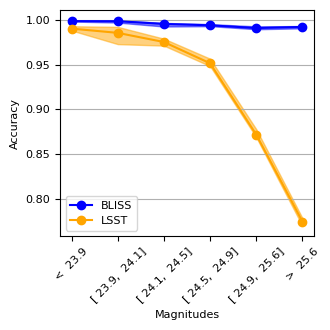

In [24]:
acc_fig = classification_acc_bs_plotting.plot("accuracy")
acc_fig.savefig(classification_acc_bs_output_dir / "classification_acc.pdf", 
                bbox_inches="tight", 
                dpi=NoteBookPlottingParams.dpi)
acc_fig.show()

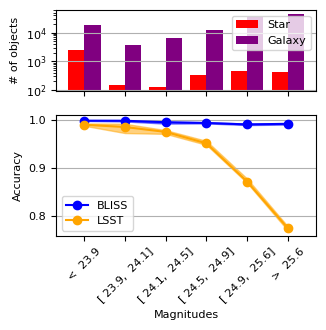

In [167]:
acc_with_state_fig = classification_acc_bs_plotting.plot("accuracy_with_state")
acc_with_state_fig.savefig(classification_acc_bs_output_dir / "classification_acc_with_state.pdf",
                           bbox_inches="tight",
                           dpi=NoteBookPlottingParams.dpi)
acc_with_state_fig.show()

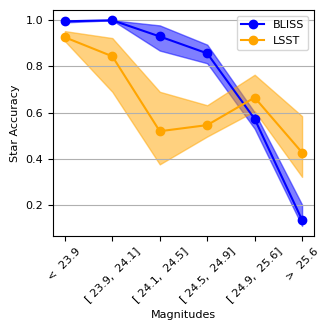

In [26]:
star_acc_fig = classification_acc_bs_plotting.plot("star_accuracy")
star_acc_fig.savefig(classification_acc_bs_output_dir / "classification_star_acc.pdf", 
                     bbox_inches="tight", 
                     dpi=NoteBookPlottingParams.dpi)
star_acc_fig.show()

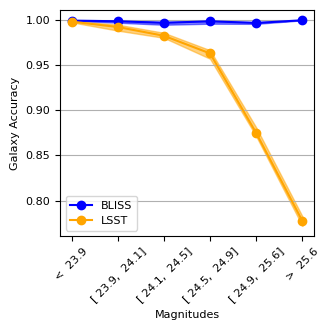

In [27]:
gal_acc_fig = classification_acc_bs_plotting.plot("galaxy_accuracy")
gal_acc_fig.savefig(classification_acc_bs_output_dir / "classification_gal_acc.pdf", 
                     bbox_inches="tight", 
                     dpi=NoteBookPlottingParams.dpi)
gal_acc_fig.show()

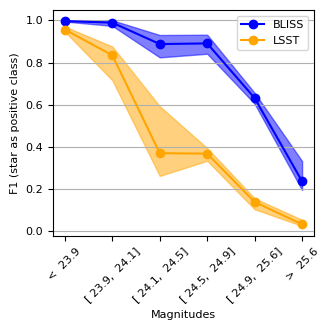

In [28]:
star_f1_fig = classification_acc_bs_plotting.plot("star_f1")
star_f1_fig.savefig(classification_acc_bs_output_dir / "classification_star_f1.pdf", 
                     bbox_inches="tight", 
                     dpi=NoteBookPlottingParams.dpi)
star_f1_fig.show()

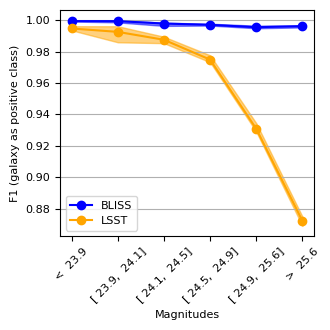

In [29]:
gal_f1_fig = classification_acc_bs_plotting.plot("galaxy_f1")
gal_f1_fig.savefig(classification_acc_bs_output_dir / "classification_gal_f1.pdf", 
                     bbox_inches="tight", 
                     dpi=NoteBookPlottingParams.dpi)
gal_f1_fig.show()

#### On One 4000 x 4000 Image

In [30]:
classification_acc_output_dir = output_dir / "classification_acc"
classification_acc_output_dir.mkdir(exist_ok=True)

In [31]:
class ClassificationAccPlotting:
    def __init__(self, 
                 bliss_metric_internal_states: Dict[str, torch.Tensor], 
                 lsst_metric_internal_states: Dict[str, torch.Tensor], 
                 bin_cutoffs: List[float]):
        self.bliss_metric_internal_states = bliss_metric_internal_states
        self.lsst_metric_internal_states = lsst_metric_internal_states
        self.xlabels = (
            [f"< {bin_cutoffs[0]: .1f}"]
            + [f"[{bin_cutoffs[i]: .1f}, {bin_cutoffs[i + 1]: .1f}]" for i in range(len(bin_cutoffs) - 1)]
            + [f"> {bin_cutoffs[-1]: .1f}"]
        )
        self.bar_plot_data = {
            "True Star Detections": self.bliss_metric_internal_states["star_tp"],
            "Number of Star": self.bliss_metric_internal_states["n_matches"] - self.bliss_metric_internal_states["gal_tp"] - self.bliss_metric_internal_states["star_fp"],
            "True Galaxy Detections": self.bliss_metric_internal_states["gal_tp"],
            "Number of Galaxy": self.bliss_metric_internal_states["n_matches"] - self.bliss_metric_internal_states["star_tp"] - self.bliss_metric_internal_states["gal_fp"],
        }

    @classmethod
    def get_f1(cls, metric_internal_states, galaxy: bool):
        if galaxy:
            recall = metric_internal_states["gal_tp"] / (metric_internal_states["gal_tp"] + metric_internal_states["star_fp"])
            precision = metric_internal_states["gal_tp"] / (metric_internal_states["gal_tp"] + metric_internal_states["gal_fp"])
        else:
            recall = metric_internal_states["star_tp"] / (metric_internal_states["star_tp"] + metric_internal_states["gal_fp"])
            precision = metric_internal_states["star_tp"] / (metric_internal_states["star_tp"] + metric_internal_states["star_fp"])
        f1 = 2 * precision * recall / (precision + recall)
        return f1

    def _one_plot(self):
        fig, ax = plt.subplots(
            1, 1, figsize=NoteBookPlottingParams.figsize, layout="constrained"
        )

        x = np.arange(len(self.xlabels)) * 45
        bar_width = 10
        multiplier = 0

        for i, (data_name, data) in enumerate(self.bar_plot_data.items()):
            offset = bar_width * multiplier
            rects = ax.bar(x + offset, data, bar_width, 
                           color=NoteBookPlottingParams.color_dict["classification_acc_bar_plot"]["bar_colors"][i], 
                           label=data_name)
            # ax.bar_label(rects, padding=3, fontsize=6)
            multiplier += 1

        ax.set_ylabel("Count", fontsize=NoteBookPlottingParams.fontsize)
        ax.set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(self.xlabels, rotation=45)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.set_yscale("log")
        ax.set_ylim(top=1e5)
        ax.grid(visible=False, axis="x")
        ax.legend(loc="upper right", fontsize=NoteBookPlottingParams.fontsize)
        
        ax2 = ax.twinx()

        bliss_gal_f1,  = ax2.plot(
            x + bar_width,
            self.get_f1(self.bliss_metric_internal_states, galaxy=True),
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label=f"BLISS F1",
        )
        lsst_gal_f1,  = ax2.plot(
            x + bar_width,
            self.get_f1(self.lsst_metric_internal_states, galaxy=True),
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label=f"LSST F1",
        )
        
        ax2.set_ylabel("Classification F1", fontsize=NoteBookPlottingParams.fontsize)
        ax2.grid(visible=False, axis="both")
        fig.legend(handles=[bliss_gal_f1, lsst_gal_f1], loc="outside upper center", ncols=2, fontsize=NoteBookPlottingParams.fontsize)

        return fig
    
    def _separate_plots(self):
        fig1, ax1 = plt.subplots(
            1, 1, figsize=NoteBookPlottingParams.figsize, layout="constrained"
        )

        x = np.arange(len(self.xlabels)) * 45
        bar_width = 10
        multiplier = 0

        for i, (data_name, data) in enumerate(self.bar_plot_data.items()):
            offset = bar_width * multiplier
            rects = ax1.bar(x + offset, data, bar_width, 
                            color=NoteBookPlottingParams.color_dict["classification_acc_bar_plot"]["bar_colors"][i], 
                            label=data_name)
            # ax1.bar_label(rects, padding=3, fontsize=9)
            multiplier += 1

        ax1.set_ylabel("Count", fontsize=NoteBookPlottingParams.fontsize)
        ax1.set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        ax1.set_xticks(x + bar_width)
        ax1.set_xticklabels(self.xlabels, rotation=45)
        ax1.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax1.set_yscale("log")
        ax1.set_ylim(top=1e5)
        ax1.grid(visible=False, axis="x")
        ax1.grid(visible=True, axis="y")
        ax1.legend(loc="upper right", fontsize=NoteBookPlottingParams.fontsize)
        
        fig2, ax2 = plt.subplots(
            1, 1, figsize=NoteBookPlottingParams.figsize, layout="constrained"
        )
        
        ax2.plot(
            x + bar_width,
            self.get_f1(self.bliss_metric_internal_states, galaxy=True),
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label=f"BLISS galaxy F1",
        )
        ax2.plot(
            x + bar_width,
            self.get_f1(self.lsst_metric_internal_states, galaxy=True),
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label=f"LSST galaxy F1",
        )
        
        ax2.set_ylabel("Classification F1", fontsize=NoteBookPlottingParams.fontsize)
        ax2.set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        ax2.set_xticks(x + bar_width)
        ax2.set_xticklabels(self.xlabels, rotation=45)
        ax2.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax2.grid(visible=False, axis="x")
        ax2.grid(visible=True, axis="y")
        ax2.legend(fontsize=NoteBookPlottingParams.fontsize)


        fig3, ax3 = plt.subplots(
            1, 1, figsize=NoteBookPlottingParams.figsize, layout="constrained"
        )
    
        ax3.plot(
            x + bar_width,
            self.get_f1(self.bliss_metric_internal_states, galaxy=False),
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label=f"BLISS star F1",
        )
        ax3.plot(
            x + bar_width,
            self.get_f1(self.lsst_metric_internal_states, galaxy=False),
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label=f"LSST star F1",
        )
        
        ax3.set_ylabel("Classification F1", fontsize=NoteBookPlottingParams.fontsize)
        ax3.set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        ax3.set_xticks(x + bar_width)
        ax3.set_xticklabels(self.xlabels, rotation=45)
        ax3.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax3.grid(visible=False, axis="x")
        ax3.grid(visible=True, axis="y")
        ax3.legend(fontsize=NoteBookPlottingParams.fontsize)

        return fig1, fig2, fig3

    def plot(self, plot_type: str):
        match plot_type:
            case "one_plot":
                return self._one_plot()
            case "separate_plots":
                return self._separate_plots()
            case _:
                raise NotImplementedError()

In [32]:
def get_classification_acc_plotting():
    bliss_metrics = SourceTypeAccuracy(base_flux_bin_cutoffs=base_flux_bin_cutoffs, 
                                       mag_zero_point=mag_zero_point, 
                                       report_bin_unit="mag")
    lsst_metrics = bliss_metrics.clone()

    bliss_matching = list(matcher.match_catalogs(test_4000x4000_results.test_image_full_cat, 
                                                test_4000x4000_results.bliss_full_cat)[0])
    lsst_matching = list(matcher.match_catalogs(test_4000x4000_results.test_image_full_cat, 
                                                test_4000x4000_results.lsst_full_cat)[0])

    bliss_metrics.update(test_4000x4000_results.test_image_full_cat, 
                        test_4000x4000_results.bliss_full_cat, 
                        [bliss_matching])
    lsst_metrics.update(test_4000x4000_results.test_image_full_cat, 
                        test_4000x4000_results.lsst_full_cat, 
                        [lsst_matching])

    bliss_metric_internal_states = bliss_metrics.get_internal_states()
    lsst_metric_internal_states = lsst_metrics.get_internal_states()

    return ClassificationAccPlotting(bliss_metric_internal_states,
                                     lsst_metric_internal_states,
                                     bliss_metrics.get_report_bins())

In [33]:
classification_acc_plotting = get_classification_acc_plotting()

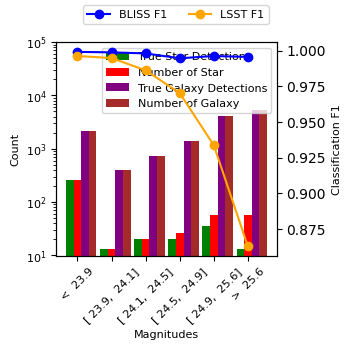

In [34]:
fig1 = classification_acc_plotting.plot("one_plot")
fig1.savefig(classification_acc_output_dir / "classification_acc.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig1.show()

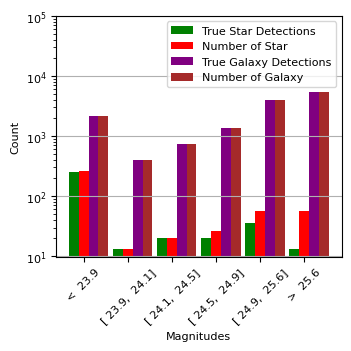

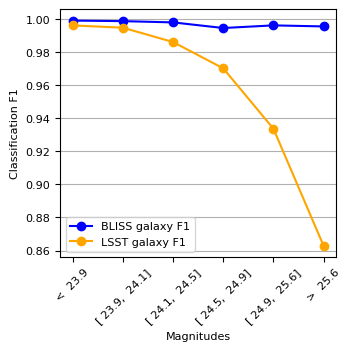

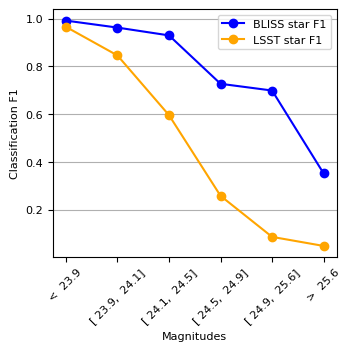

In [35]:
fig1, fig2, fig3 = classification_acc_plotting.plot("separate_plots")

fig1.savefig(classification_acc_output_dir / "classification_acc_tp.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig1.show()

fig2.savefig(classification_acc_output_dir / "classification_galaxy_f1.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig2.show()

fig3.savefig(classification_acc_output_dir / "classification_star_f1.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig3.show()

In [148]:
class ClassificationAccThresholdPlotting:
    def __init__(self, 
                 test_image_full_cat: FullCatalog,
                 bliss_full_cat: FullCatalog,
                 matcher: CatalogMatcher):
        bliss_matching = list(matcher.match_catalogs(test_image_full_cat, bliss_full_cat)[0])

        self.true_galaxy = (test_image_full_cat["source_type"][0, bliss_matching[0].tolist(), 0] == 1)
        self.true_galaxy_fluxes = test_image_full_cat["galaxy_fluxes"][0, bliss_matching[0].tolist(), 2]
        self.est_galaxy_probs = bliss_full_cat["source_type_probs"][0, bliss_matching[1].tolist(), 1]
    
    @classmethod
    def acc_wrt_thresholds(cls, true_cls, est_probs, thredsholds):
        acc = torch.zeros(len(thredsholds))
        for i, threshold in enumerate(thredsholds):
            est_cls = est_probs >= threshold
            acc[i] = (est_cls[true_cls]).sum() / true_cls.sum()
        return acc
    
    def _threshold_plot(self):
        thresholds = [i / 100 for i in range(0, 100, 20)]

        fig, axes = plt.subplots(nrows=1, ncols=3,
                                figsize=(NoteBookPlottingParams.figsize[0] * 2.5, NoteBookPlottingParams.figsize[1]),
                                sharey="row")
        x = list(range(len(thresholds)))
        total_acc = self.acc_wrt_thresholds(self.true_galaxy, self.est_galaxy_probs, thresholds)
        axes[0].plot(x, total_acc, "-o", color="blue")
        axes[0].set_xlabel("Thresholds", fontsize=NoteBookPlottingParams.fontsize)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(thresholds)
        axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[0].set_title("All Sources", fontdict={"fontsize": NoteBookPlottingParams.fontsize})
        axes[0].set_ylabel("Proportion of True Galaxies Predicted", fontsize=NoteBookPlottingParams.fontsize)
        axes[0].grid(visible=True, axis="y")
        axes[0].grid(visible=False, axis="x")

        dim_filter = self.true_galaxy_fluxes < 200
        dim_acc = self.acc_wrt_thresholds(self.true_galaxy[dim_filter], self.est_galaxy_probs[dim_filter], thresholds)
        axes[1].plot(x, dim_acc, "-o", color="blue")
        axes[1].set_xlabel("Thresholds", fontsize=NoteBookPlottingParams.fontsize)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(thresholds)
        axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[1].set_title("Dim Sources (Magnitudes > 24.9)", fontdict={"fontsize": NoteBookPlottingParams.fontsize})
        axes[1].grid(visible=True, axis="y")
        axes[1].grid(visible=False, axis="x")

        bright_filter = self.true_galaxy_fluxes > 800
        bright_acc = self.acc_wrt_thresholds(self.true_galaxy[bright_filter], self.est_galaxy_probs[bright_filter], thresholds)
        axes[2].plot(x, bright_acc, "-o", color="blue")
        axes[2].set_xlabel("Thresholds", fontsize=NoteBookPlottingParams.fontsize)
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(thresholds)
        axes[2].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[2].set_title("Bright Sources (Magnitudes < 24.1)", fontdict={"fontsize": NoteBookPlottingParams.fontsize})
        axes[2].grid(visible=True, axis="y")
        axes[2].grid(visible=False, axis="x")

        return fig
    
    def _roc_plot(self):
        fig, ax = plt.subplots(nrows=1, ncols=1, 
                                figsize=NoteBookPlottingParams.figsize)

        dim_filter = self.true_galaxy_fluxes < 200
        fpr, tpr, _thresholds = sklearn.metrics.roc_curve(self.true_galaxy[dim_filter], 
                                                          self.est_galaxy_probs[dim_filter])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Faint AUC ={roc_auc: .3f}", color=NoteBookPlottingParams.color_dict["roc_plot"]["faint"])
        

        bright_filter = self.true_galaxy_fluxes > 200
        fpr, tpr, _thresholds = sklearn.metrics.roc_curve(self.true_galaxy[bright_filter], 
                                                          self.est_galaxy_probs[bright_filter])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Bright AUC ={roc_auc: .3f}", color=NoteBookPlottingParams.color_dict["roc_plot"]["bright"])

        x = [0, 1]
        y = [0, 1]
        ax.plot(x, y, color="grey", alpha=0.8, linestyle="dashed")

        ax.legend(fontsize=NoteBookPlottingParams.fontsize)
        ax.set_xlabel("False Positive Rate", fontsize=NoteBookPlottingParams.fontsize)
        ax.set_ylabel("True Positive Rate", fontsize=NoteBookPlottingParams.fontsize)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)

        return fig
    
    def plot(self, plot_type: str):
        match plot_type:
            case "threshold_plot":
                return self._threshold_plot()
            case "roc_plot":
                return self._roc_plot()
            case _:
                raise NotImplementedError()

In [149]:
def get_classification_acc_threshold_plotting():
    return ClassificationAccThresholdPlotting(test_4000x4000_results.test_image_full_cat,
                                              test_4000x4000_results.bliss_full_cat,
                                              matcher)

In [150]:
classification_acc_threshold_plotting = get_classification_acc_threshold_plotting()

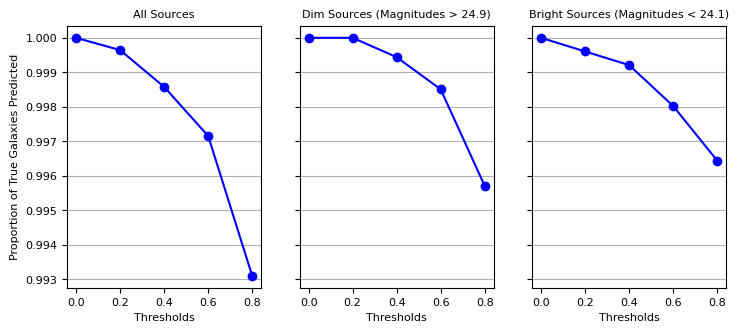

In [39]:
threshold_fig = classification_acc_threshold_plotting.plot("threshold_plot")
threshold_fig.savefig(classification_acc_output_dir / "classification_threshold_plot.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
threshold_fig.show()

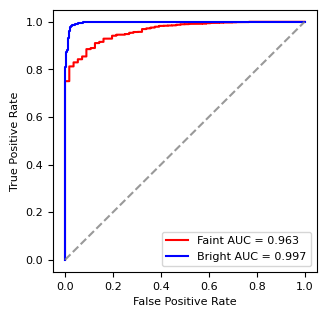

In [151]:
roc_fig = classification_acc_threshold_plotting.plot("roc_plot")
roc_fig.savefig(classification_acc_output_dir / "roc_plot.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
roc_fig.show()

### Detection

#### Bootstrap

In [41]:
detection_bs_output_dir = output_dir / "detection_bs"
detection_bs_output_dir.mkdir(exist_ok=True)

In [42]:
class DetectionBSPlotting:
    def __init__(self, 
                 bliss_metric_internal_states: Dict[str, torch.Tensor],
                 lsst_metric_internal_states: Dict[str, torch.Tensor],
                 bin_cutoffs: torch.Tensor):
        self.quantile_points = torch.tensor([0.05, 0.5, 0.95])
        self.bliss_metric_internal_states = bliss_metric_internal_states
        self.lsst_metric_internal_states = lsst_metric_internal_states
        self.xlabels = (
            [f"< {bin_cutoffs[0]: .1f}"]
            + [f"[{bin_cutoffs[i]: .1f}, {bin_cutoffs[i + 1]: .1f}]" for i in range(len(bin_cutoffs) - 1)]
            + [f"> {bin_cutoffs[-1]: .1f}"]
        )

    def calculate_recall_precision_f1(self, metric_internal_states: Dict[str, torch.Tensor], postfix_str: str):
        recall_list = (metric_internal_states[f"n_true_matches{postfix_str}"] / metric_internal_states[f"n_true_sources{postfix_str}"]).nan_to_num(0)
        recall_matrix = recall_list.quantile(q=self.quantile_points, dim=0)
        precision_list = (metric_internal_states[f"n_est_matches{postfix_str}"] / metric_internal_states[f"n_est_sources{postfix_str}"]).nan_to_num(0)
        precision_matrix = precision_list.quantile(q=self.quantile_points, dim=0)
        f1_list = (2 * precision_list * recall_list / (precision_list + recall_list)).nan_to_num(0)
        f1_matrix = f1_list.quantile(q=self.quantile_points, dim=0)
        return recall_matrix, precision_matrix, f1_matrix

    def _plot(self, postfix_str: str):
        bliss_recall_matrix, bliss_precision_matrix, bliss_f1_matrix = self.calculate_recall_precision_f1(self.bliss_metric_internal_states, 
                                                                                                          postfix_str=postfix_str)
        lsst_recall_matrix, lsst_precision_matrix, lsst_f1_matrix = self.calculate_recall_precision_f1(self.lsst_metric_internal_states, 
                                                                                                       postfix_str=postfix_str)

        x = np.array(list(range(len(self.xlabels))))
        bar_width = 0.4

        graph_tag = f"({postfix_str[1:]})" if postfix_str else ""

        # recall
        recall_fig, recall_axes = plt.subplots(
            2, 1, 
            figsize=(NoteBookPlottingParams.figsize[0], NoteBookPlottingParams.figsize[1]), 
            gridspec_kw={"height_ratios": [2, 3]}, 
            sharex="col"
        )
        recall_axes[1].plot(
            x,
            bliss_recall_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label=f"BLISS {graph_tag}",
        )
        recall_axes[1].fill_between(
            x,
            bliss_recall_matrix[0, :],
            bliss_recall_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["bliss"],
            alpha=0.5,
        )
        recall_axes[1].plot(
            x,
            lsst_recall_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label=f"LSST {graph_tag}",
        )
        recall_axes[1].fill_between(
            x,
            lsst_recall_matrix[0, :],
            lsst_recall_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["lsst"],
            alpha=0.5,
        )
        recall_axes[1].set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[1].set_xticks(x)
        recall_axes[1].set_xticklabels(self.xlabels, rotation=45)
        recall_axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        recall_axes[1].set_ylim(bottom=0.5, top=1.0)
        recall_axes[1].set_ylabel("Recall", fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[1].legend(fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[0].bar(
            x,
            self.bliss_metric_internal_states[f"n_true_sources{postfix_str}"].mean(dim=0).tolist(),
            bar_width,
            label=f"ground truth {graph_tag}",
            color=NoteBookPlottingParams.color_dict["detection_bar_plot"]["ground_truth"],
        )
    
        count_max = self.bliss_metric_internal_states[f"n_true_sources{postfix_str}"].max().item()
        count_ticks = np.round(np.linspace(0, count_max, 5), -3)
        recall_axes[0].set_yticks(count_ticks)
        recall_axes[0].set_ylabel("# of objects", fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        recall_axes[0].legend(fontsize=NoteBookPlottingParams.fontsize)

        recall_axes[0].grid(visible=True, axis="y")
        recall_axes[0].grid(visible=False, axis="x")
        recall_axes[1].grid(visible=True, axis="y")
        recall_axes[1].grid(visible=False, axis="x")
        recall_fig.tight_layout()
  
        # precision
        precision_fig, precision_axes = plt.subplots(
            2, 1, 
            figsize=(NoteBookPlottingParams.figsize[0], NoteBookPlottingParams.figsize[1]), 
            gridspec_kw={"height_ratios": [2, 3]}, 
            sharex="col"
        )
        precision_axes[1].plot(
            x,
            bliss_precision_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label=f"BLISS {graph_tag}",
        )
        precision_axes[1].fill_between(
            x,
            bliss_precision_matrix[0, :],
            bliss_precision_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["bliss"],
            alpha=0.5,
        )
        precision_axes[1].plot(
            x,
            lsst_precision_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label=f"LSST {graph_tag}",
        )
        precision_axes[1].fill_between(
            x,
            lsst_precision_matrix[0, :],
            lsst_precision_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["lsst"],
            alpha=0.5,
        )
        precision_axes[1].set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        precision_axes[1].set_xticks(range(len(self.xlabels)))
        precision_axes[1].set_xticklabels(self.xlabels, rotation=45)
        precision_axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        precision_axes[1].set_ylim(bottom=0.5, top=1.0)
        precision_axes[1].set_ylabel("Precision", fontsize=NoteBookPlottingParams.fontsize)
        precision_axes[1].legend(fontsize=NoteBookPlottingParams.fontsize)
        precision_axes[0].bar(
            x - 0.5 * bar_width,
            self.bliss_metric_internal_states[f"n_est_sources{postfix_str}"].mean(dim=0).tolist(),
            bar_width,
            label=f"BLISS {graph_tag}",
            color=NoteBookPlottingParams.color_dict["bliss"],
        )
        precision_axes[0].bar(
            x + 0.5 * bar_width,
            self.lsst_metric_internal_states[f"n_est_sources{postfix_str}"].mean(dim=0).tolist(),
            bar_width,
            label=f"LSST {graph_tag}",
            color=NoteBookPlottingParams.color_dict["lsst"],
        )
        count_max = max(self.bliss_metric_internal_states[f"n_est_sources{postfix_str}"].max().item(),
                        self.lsst_metric_internal_states[f"n_est_sources{postfix_str}"].max().item())
        count_ticks = np.round(np.linspace(0, count_max, 5), -3)
        precision_axes[0].set_yticks(count_ticks)
        precision_axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        precision_axes[0].set_ylabel("# of detections", fontsize=NoteBookPlottingParams.fontsize)
        precision_axes[0].legend(fontsize=NoteBookPlottingParams.fontsize)

        precision_axes[0].grid(visible=True, axis="y")
        precision_axes[0].grid(visible=False, axis="x")
        precision_axes[1].grid(visible=True, axis="y")
        precision_axes[1].grid(visible=False, axis="x")
        precision_fig.tight_layout()

        # f1
        f1_fig, f1_axes = plt.subplots(
            2, 1, 
            figsize=(NoteBookPlottingParams.figsize[0], NoteBookPlottingParams.figsize[1]), 
            gridspec_kw={"height_ratios": [2, 3]}, 
            sharex="col"
        )
        f1_axes[1].plot(
            x,
            bliss_f1_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label=f"BLISS {graph_tag}",
        )
        f1_axes[1].fill_between(
            x,
            bliss_f1_matrix[0, :],
            bliss_f1_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["bliss"],
            alpha=0.5,
        )
        f1_axes[1].plot(
            x,
            lsst_f1_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label=f"LSST {graph_tag}",
        )
        f1_axes[1].fill_between(
            x,
            lsst_f1_matrix[0, :],
            lsst_f1_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["lsst"],
            alpha=0.5,
        )
        f1_axes[1].set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        f1_axes[1].set_xticks(range(len(self.xlabels)))
        f1_axes[1].set_xticklabels(self.xlabels, rotation=45)
        f1_axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        f1_axes[1].set_ylim(bottom=0.5, top=1.0)
        f1_axes[1].set_ylabel("F1", fontsize=NoteBookPlottingParams.fontsize)
        f1_axes[1].legend(fontsize=NoteBookPlottingParams.fontsize)
        f1_axes[0].bar(
            x - 0.5 * bar_width,
            self.bliss_metric_internal_states[f"n_est_sources{postfix_str}"].mean(dim=0).tolist(),
            bar_width,
            label=f"# of BLISS detections {graph_tag}",
            color=NoteBookPlottingParams.color_dict["bliss"],
        )
        f1_axes[0].bar(
            x + 0.5 * bar_width,
            self.lsst_metric_internal_states[f"n_est_sources{postfix_str}"].mean(dim=0).tolist(),
            bar_width,
            label=f"# of LSST detections {graph_tag}",
            color=NoteBookPlottingParams.color_dict["lsst"],
        )
        count_max = max(self.bliss_metric_internal_states[f"n_est_sources{postfix_str}"].max().item(),
                        self.lsst_metric_internal_states[f"n_est_sources{postfix_str}"].max().item())
        count_ticks = np.round(np.linspace(0, count_max, 5), -3)
        f1_axes[0].set_yticks(count_ticks)
        f1_axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        f1_axes[0].set_ylabel("# of objects", fontsize=NoteBookPlottingParams.fontsize)
        f1_axes[0].legend(fontsize=NoteBookPlottingParams.fontsize)

        f1_axes[0].grid(visible=True, axis="y")
        f1_axes[0].grid(visible=False, axis="x")
        f1_axes[1].grid(visible=True, axis="y")
        f1_axes[1].grid(visible=False, axis="x")
        f1_fig.tight_layout()

        return recall_fig, precision_fig, f1_fig

    def plot(self, plot_type: str):
        match plot_type:
            case "total":
                return self._plot(postfix_str="")
            case "star":
                return self._plot(postfix_str="_star")
            case "galaxy":
                return self._plot(postfix_str="_galaxy")
            case _:
                return NotImplementedError()

In [43]:
def get_detection_bs_plotting():
    bliss_metrics = MetricCollection({
        "detection_performance": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                      mag_zero_point=mag_zero_point,
                                                      report_bin_unit="mag"),
        "detection_performance_star": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                           mag_zero_point=mag_zero_point,
                                                           report_bin_unit="mag",
                                                           filter_list=[SourceTypeFilter(filter_type="star")]),
        "detection_performance_galaxy": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                             mag_zero_point=mag_zero_point,
                                                             report_bin_unit="mag",
                                                             filter_list=[SourceTypeFilter(filter_type="galaxy")]),
    })
    lsst_metrics = bliss_metrics.clone()

    bliss_metric_internal_states = {}
    lsst_metric_internal_states = {}

    for _epoch, results in bs_results:
        for bliss_full_cat, lsst_full_cat, target_full_cat, bliss_matching, lsst_matching in results:
            bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)
            lsst_metrics.update(target_full_cat, lsst_full_cat, lsst_matching)

        for k, v in bliss_metrics.items():
            internal_states = v.get_internal_states()
            for k_state, v_state in internal_states.items():
                if k_state not in bliss_metric_internal_states:
                    bliss_metric_internal_states[k_state] = []
                bliss_metric_internal_states[k_state].append(v_state)

        for k, v in lsst_metrics.items():
            internal_states = v.get_internal_states()
            for k_state, v_state in internal_states.items():
                if k_state not in lsst_metric_internal_states:
                    lsst_metric_internal_states[k_state] = []
                lsst_metric_internal_states[k_state].append(v_state)

        bliss_metrics.reset()
        lsst_metrics.reset()

    bliss_metric_internal_states = {k: torch.stack(v) for k, v in bliss_metric_internal_states.items()}
    lsst_metric_internal_states = {k: torch.stack(v) for k, v in lsst_metric_internal_states.items()}

    return DetectionBSPlotting(bliss_metric_internal_states,
                               lsst_metric_internal_states,
                               bliss_metrics["detection_performance"].get_report_bins())

In [44]:
detection_bs_plotting = get_detection_bs_plotting()

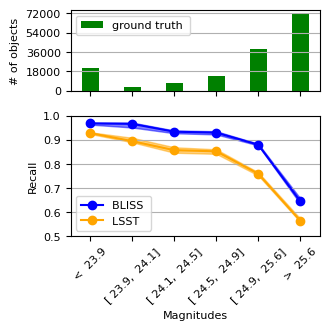

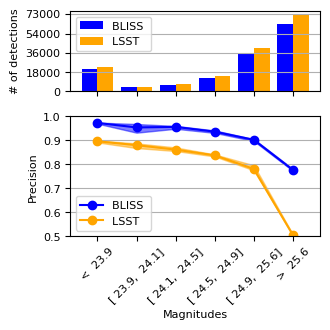

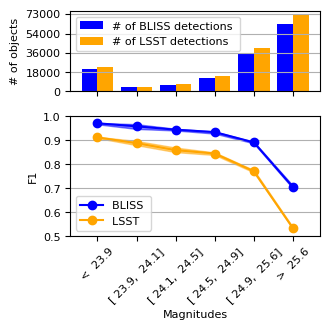

In [90]:
recall_fig, precision_fig, f1_fig = detection_bs_plotting.plot("total")
recall_fig.savefig(detection_bs_output_dir / "recall.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
recall_fig.show()
precision_fig.savefig(detection_bs_output_dir / "precision.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
precision_fig.show()
f1_fig.savefig(detection_bs_output_dir / "f1.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
f1_fig.show()

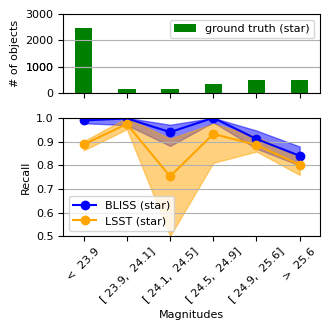

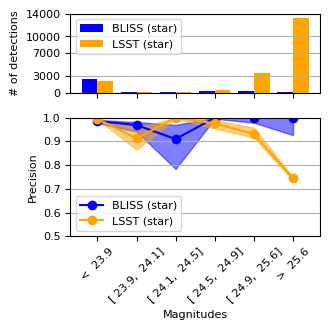

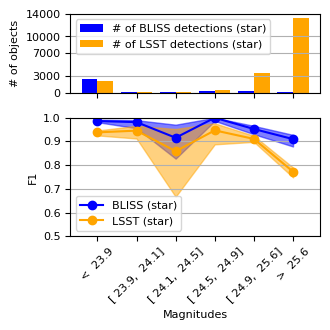

In [46]:
star_recall_fig, star_precision_fig, star_f1_fig = detection_bs_plotting.plot("star")
star_recall_fig.savefig(detection_bs_output_dir / "recall_star.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
star_recall_fig.show()
star_precision_fig.savefig(detection_bs_output_dir / "precision_star.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
star_precision_fig.show()
star_f1_fig.savefig(detection_bs_output_dir / "f1_star.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
star_f1_fig.show()

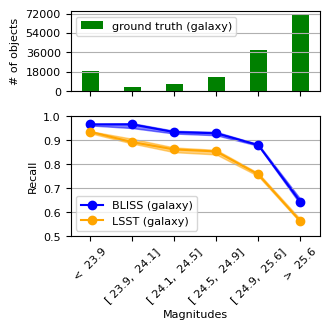

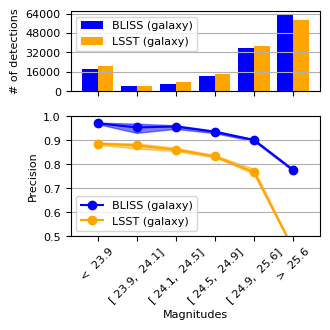

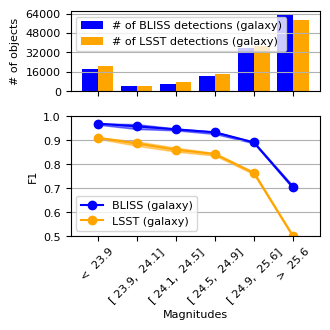

In [47]:
gal_recall_fig, gal_precision_fig, gal_f1_fig = detection_bs_plotting.plot("galaxy")
gal_recall_fig.savefig(detection_bs_output_dir / "recall_galaxy.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
gal_recall_fig.show()
gal_precision_fig.savefig(detection_bs_output_dir / "precision_galaxy.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
gal_precision_fig.show()
gal_f1_fig.savefig(detection_bs_output_dir / "f1_galaxy.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
gal_f1_fig.show()

#### Bootstrap (w.r.t Blendedness)

In [48]:
detection_bs_blendedness_output_dir = output_dir / "detection_bs_blendedness"
detection_bs_blendedness_output_dir.mkdir(exist_ok=True)

In [49]:
class DetectionBSBlendednessPlotting:
    def __init__(self, 
                 bliss_metric_internal_states: Dict[str, torch.Tensor],
                 lsst_metric_internal_states: Dict[str, torch.Tensor],
                 bin_cutoffs: List[float]):
        self.quantile_points = torch.tensor([0.05, 0.5, 0.95])
        self.bliss_metric_internal_states = bliss_metric_internal_states
        self.lsst_metric_internal_states = lsst_metric_internal_states
        self.xlabels = (
            ["< " + str(bin_cutoffs[0])]
            + [f"[{bin_cutoffs[i]}, {bin_cutoffs[i + 1]}]" for i in range(len(bin_cutoffs) - 1)]
            + ["> " + str(bin_cutoffs[-1])]
        )

    def calculate_recall(self, metric_internal_states: Dict[str, torch.Tensor]):
        recall_list = (metric_internal_states["n_true_matches"] / metric_internal_states["n_true_sources"]).nan_to_num(0)
        recall_matrix = recall_list.quantile(q=self.quantile_points, dim=0)
        return recall_matrix

    def plot(self):
        bliss_recall_matrix = self.calculate_recall(self.bliss_metric_internal_states)
        lsst_recall_matrix = self.calculate_recall(self.lsst_metric_internal_states)

        x = np.array(list(range(len(self.xlabels))))
        bar_width = 0.4

        # recall
        recall_fig, recall_axes = plt.subplots(
            2, 1, 
            figsize=(NoteBookPlottingParams.figsize[0], NoteBookPlottingParams.figsize[1]), 
            gridspec_kw={"height_ratios": [2, 3]}, 
            sharex="col"
        )
        recall_axes[1].plot(
            x,
            bliss_recall_matrix[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label=f"BLISS",
        )
        recall_axes[1].fill_between(
            x,
            bliss_recall_matrix[0, :],
            bliss_recall_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["bliss"],
            alpha=0.5,
        )
        recall_axes[1].plot(
            x,
            lsst_recall_matrix[1, :].tolist(),
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label=f"LSST",
        )
        recall_axes[1].fill_between(
            x,
            lsst_recall_matrix[0, :],
            lsst_recall_matrix[2, :],
            color=NoteBookPlottingParams.color_dict["lsst"],
            alpha=0.5,
        )
        recall_axes[1].set_xlabel("Blendedness", fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[1].set_xticks(x)
        recall_axes[1].set_xticklabels(self.xlabels, rotation=45)
        recall_axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        recall_axes[1].set_ylim(bottom=0.5, top=1.0)
        recall_axes[1].set_ylabel("Recall", fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[1].legend(fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[0].bar(
            x,
            self.bliss_metric_internal_states["n_true_sources"].mean(dim=0).tolist(),
            bar_width,
            label="ground truth",
            color=NoteBookPlottingParams.color_dict["detection_bar_plot"]["ground_truth"],
        )
    
        count_max = self.bliss_metric_internal_states["n_true_sources"].max().item()
        count_ticks = np.round(np.linspace(0, count_max, 5), -3)
        recall_axes[0].set_yticks(count_ticks)
        recall_axes[0].set_ylabel("# of objects", fontsize=NoteBookPlottingParams.fontsize)
        recall_axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        recall_axes[0].legend(fontsize=NoteBookPlottingParams.fontsize)

        recall_axes[0].grid(visible=True, axis="y")
        recall_axes[0].grid(visible=False, axis="x")
        recall_axes[1].grid(visible=True, axis="y")
        recall_axes[1].grid(visible=False, axis="x")
        recall_fig.tight_layout()

        return recall_fig

In [50]:
def get_detection_bs_blendedness_plotting():
    bliss_metrics = DetectionRecallwrtBlendedness(bin_cutoffs=blendedness_bin_cutoffs)
    lsst_metrics = bliss_metrics.clone()

    bliss_metric_internal_states = {}
    lsst_metric_internal_states = {}

    for _epoch, results in bs_results:
        for bliss_full_cat, lsst_full_cat, target_full_cat, bliss_matching, lsst_matching in results:
            bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)
            lsst_metrics.update(target_full_cat, lsst_full_cat, lsst_matching)

        metric_internal_states = bliss_metrics.get_internal_states()
        for k_state, v_state in metric_internal_states.items():
            if k_state not in bliss_metric_internal_states:
                bliss_metric_internal_states[k_state] = []
            bliss_metric_internal_states[k_state].append(v_state)

        metric_internal_states = lsst_metrics.get_internal_states()
        for k_state, v_state in metric_internal_states.items():
            if k_state not in lsst_metric_internal_states:
                lsst_metric_internal_states[k_state] = []
            lsst_metric_internal_states[k_state].append(v_state)

        bliss_metrics.reset()
        lsst_metrics.reset()

    bliss_metric_internal_states = {k: torch.stack(v) for k, v in bliss_metric_internal_states.items()}
    lsst_metric_internal_states = {k: torch.stack(v) for k, v in lsst_metric_internal_states.items()}

    return DetectionBSBlendednessPlotting(bliss_metric_internal_states,
                                          lsst_metric_internal_states,
                                          blendedness_bin_cutoffs)

In [51]:
detection_bs_blendedness_plotting = get_detection_bs_blendedness_plotting()

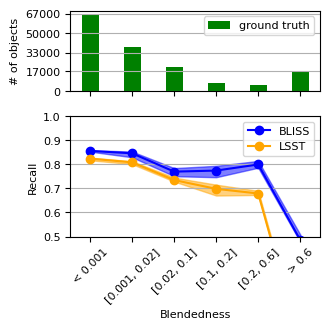

In [52]:
fig = detection_bs_blendedness_plotting.plot()
fig.savefig(detection_bs_blendedness_output_dir / "recall_blendedness.pdf", 
                   bbox_inches="tight", 
                   dpi=NoteBookPlottingParams.dpi)
fig.show()

### Flux Error

#### On One 4000x4000 Image

In [53]:
flux_error_output_dir = output_dir / "flux_error"
flux_error_output_dir.mkdir(exist_ok=True)

In [98]:
class FluxErrorPlotting:
    def __init__(self, 
                 test_image_full_cat: FullCatalog,
                 bliss_full_cat: FullCatalog,
                 lsst_full_cat: FullCatalog,
                 bin_cutoffs: List[float]):
        assert test_image_full_cat["n_sources"].shape[0] == 1
        assert bliss_full_cat["n_sources"].shape[0] == 1
        assert lsst_full_cat["n_sources"].shape[0] == 1

        bliss_matching = list(matcher.match_catalogs(test_image_full_cat, bliss_full_cat)[0])
        lsst_matching = list(matcher.match_catalogs(test_image_full_cat, lsst_full_cat)[0])

        matching_inter = (bliss_matching[0].view(-1, 1) == lsst_matching[0].view(1, -1))
        bliss_matching[0], bliss_matching[1] = bliss_matching[0][matching_inter.any(dim=-1)], bliss_matching[1][matching_inter.any(dim=-1)]
        lsst_matching[0], lsst_matching[1] = lsst_matching[0][matching_inter.any(dim=0)], lsst_matching[1][matching_inter.any(dim=0)]

        bin_cutoffs = torch.tensor(bin_cutoffs)
        n_bins = bin_cutoffs.shape[0] + 1

        true_flux = test_image_full_cat.on_fluxes[0, bliss_matching[0], :]
        bucketized_true_flux = torch.bucketize(true_flux, bin_cutoffs)
        bliss_flux = bliss_full_cat.on_fluxes[0, bliss_matching[1], :]
        flux_err = (true_flux - bliss_flux) / true_flux
        self.bliss_flux_err_dict = {i: [] for i in bands}
        for band_idx, band_name in enumerate(bands):
            for flux_bin_idx in range(n_bins):
                self.bliss_flux_err_dict[band_name].append(
                    flux_err[bucketized_true_flux[:, band_idx] == flux_bin_idx, band_idx].tolist()
                )

        true_flux = test_image_full_cat.on_fluxes[0, lsst_matching[0], :]
        bucketized_true_flux = torch.bucketize(true_flux, bin_cutoffs)
        lsst_flux = lsst_full_cat.on_fluxes[0, lsst_matching[1], :]
        flux_err = (true_flux - lsst_flux) / true_flux
        self.lsst_flux_err_dict = {i: [] for i in bands}
        for band_idx, band_name in enumerate(bands):
            for flux_bin_idx in range(n_bins):
                self.lsst_flux_err_dict[band_name].append(
                    flux_err[bucketized_true_flux[:, band_idx] == flux_bin_idx, band_idx].tolist()
                )

        self.xlabels = (
            ["[100, " + str(bin_cutoffs[0].item()) + "]"]
            + [f"[{bin_cutoffs[i].item()}, {bin_cutoffs[i + 1].item()}]" for i in range(len(bin_cutoffs) - 1)]
            + ["> " + str(bin_cutoffs[-1].item())]
        )

    @classmethod
    def filter_nan(cls, data):
        output_data = []
        for sub_data in data:
            sub_data = np.array(sub_data)
            sub_data = sub_data[~np.isnan(sub_data)]
            output_data.append(sub_data.tolist())
        return output_data
    
    @classmethod
    def set_box_color(cls, bp, color):
        plt.setp(bp["boxes"], color=color)
        plt.setp(bp["whiskers"], color=color)
        plt.setp(bp["caps"], color=color)
        plt.setp(bp["medians"], color=color)

    def _one_plot(self):
        fig, axes = plt.subplots(2, 1, 
                                 figsize=(NoteBookPlottingParams.figsize[0], NoteBookPlottingParams.figsize[1] * 1.5), 
                                 sharex="col", 
                                 layout="constrained")

        x = np.array(list(range(len(bands)))) * 3
        bar_width = 0.3
        bar_to_bar_width = 0.4

        for i, (k, v) in enumerate(self.bliss_flux_err_dict.items()):
            bp = axes[1].boxplot(self.filter_nan(v), 
                                 positions=x + bar_to_bar_width * i, 
                                 sym="", widths=bar_width)
            self.set_box_color(bp, NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][i])

        axes[1].set_ylabel("BLISS Residual Proportion", fontsize=NoteBookPlottingParams.fontsize)
        axes[1].set_ylim(-1.0, 1.0)

        for i, (k, v) in enumerate(self.lsst_flux_err_dict.items()):
            bp = axes[0].boxplot(self.filter_nan(v), 
                                 positions=x + bar_to_bar_width * i, 
                                 sym="", widths=bar_width)
            self.set_box_color(bp, NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][i])

        axes[0].set_ylabel("LSST Residual Proportion", fontsize=NoteBookPlottingParams.fontsize)
        axes[0].set_ylim(-1.0, 1.0)
        axes[0].set_xticks(x + bar_to_bar_width * (len(bands) // 2))
        axes[1].set_xticklabels(self.xlabels, rotation=45)
        axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[0].set_xlim(left=-0.5)
        axes[1].set_xlabel("Flux (nJy)", fontsize=NoteBookPlottingParams.fontsize)

        legend_handles = [mpatches.Patch(color=NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][0], 
                                         label="u band"),
                          mpatches.Patch(color=NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][3], 
                                         label="i band"),
                          mpatches.Patch(color=NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][1], 
                                         label="g band"),
                          mpatches.Patch(color=NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][4], 
                                         label="z band"),
                          mpatches.Patch(color=NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][2], 
                                         label="r band"),
                          mpatches.Patch(color=NoteBookPlottingParams.color_dict["flux_error_plot"]["band_colors"][5], 
                                         label="y band")]
        fig.legend(handles=legend_handles,
                loc="outside upper center", fancybox=True, shadow=False, ncol=3,
                fontsize=NoteBookPlottingParams.fontsize)
        axes[0].grid(visible=False, axis="x")
        axes[0].grid(visible=True, axis="y")
        axes[1].grid(visible=False, axis="x")
        axes[1].grid(visible=True, axis="y")

        return fig
    
    def _separate_plots(self):
        fig, axes = plt.subplots(3, 2, 
                         figsize=(NoteBookPlottingParams.figsize[0] * 1.1, NoteBookPlottingParams.figsize[1] * 2), 
                         sharex="col", 
                         sharey="row",
                         layout="constrained")

        box_offset = np.array(list(range(len(bands)))) * 1.5
        for i, band in enumerate(bands):
            col_index = i % 2
            row_index = i // 2
            ax = axes[row_index, col_index]
            bliss_flux_err = self.bliss_flux_err_dict[band]
            lsst_flux_err = self.lsst_flux_err_dict[band]
            bp = ax.boxplot(self.filter_nan(bliss_flux_err), positions=box_offset, sym="", widths=0.3)
            self.set_box_color(bp, NoteBookPlottingParams.color_dict["bliss"])
            bp = ax.boxplot(self.filter_nan(lsst_flux_err), positions=box_offset + 0.4, sym="", widths=0.3)
            self.set_box_color(bp, NoteBookPlottingParams.color_dict["lsst"])
            ax.set_title(f"{band} band", fontsize=NoteBookPlottingParams.fontsize)
            ax.set_ylim(-1.0, 1.0)
            ax.grid(visible=False, axis="x")
            ax.grid(visible=True, axis="y")
            
        axes[1, 0].set_ylabel("Residual Proportion", fontsize=NoteBookPlottingParams.fontsize)
        axes[2, 0].set_xticks(box_offset + 0.2)
        axes[2, 0].set_xticklabels(self.xlabels, rotation=45)
        axes[0, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[1, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[2, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[2, 0].set_xlim(left=-0.5)
        axes[2, 0].set_xlabel("Flux (nJy)", fontsize=NoteBookPlottingParams.fontsize)
        axes[2, 1].set_xticks(box_offset + 0.2)
        axes[2, 1].set_xticklabels(self.xlabels, rotation=45)
        axes[2, 1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[2, 1].set_xlim(left=-0.5)
        axes[2, 1].set_xlabel("Flux (nJy)", fontsize=NoteBookPlottingParams.fontsize)

        fig.legend(handles=[mpatches.Patch(color=NoteBookPlottingParams.color_dict["bliss"], label="BLISS"),
                            mpatches.Patch(color=NoteBookPlottingParams.color_dict["lsst"], label="LSST")],
                loc="outside upper center", fancybox=True, shadow=False, ncol=2,
                fontsize=NoteBookPlottingParams.fontsize)
        
        return fig

    def plot(self, plot_type: str):
        match plot_type:
            case "one_plot":
                return self._one_plot()
            case "separate_plots":
                return self._separate_plots()
            case _:
                raise NotImplementedError()

In [100]:
def get_flux_error_plotting():
    return FluxErrorPlotting(test_4000x4000_results.test_image_full_cat,
                             test_4000x4000_results.bliss_full_cat,
                             test_4000x4000_results.lsst_full_cat,
                             base_flux_bin_cutoffs)

In [101]:
flux_error_plotting = get_flux_error_plotting()

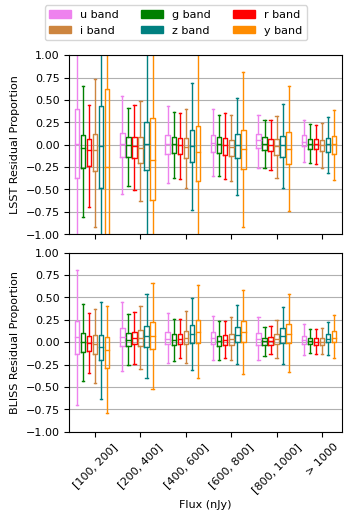

In [57]:
fig1 = flux_error_plotting.plot("one_plot")
fig1.savefig(flux_error_output_dir / "flux_err.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig1.show()

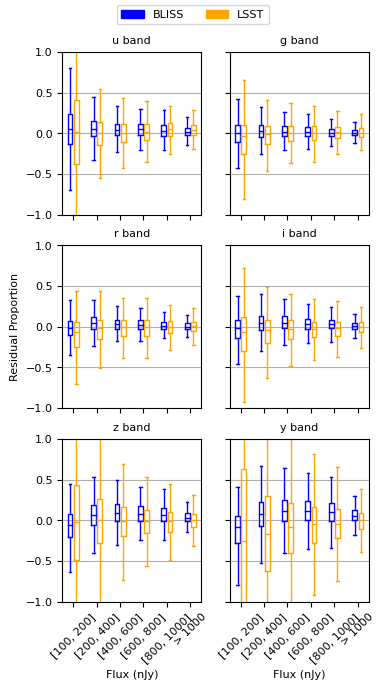

In [102]:
fig1 = flux_error_plotting.plot("separate_plots")
fig1.savefig(flux_error_output_dir / "flux_err_separate.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig1.show()

### Ellipticity

#### Bootstrap

In [59]:
ellipticity_output_dir = output_dir / "ellipticity"
ellipticity_output_dir.mkdir(exist_ok=True)

In [60]:
class EllipticityPlotting:
    def __init__(self, 
                 mag_metric_results, 
                 blendedness_metric_results, 
                 mag_bin_cutoffs, 
                 blendedness_bin_cutoffs):
        quantile_points = torch.tensor([0.05, 0.5, 0.95])

        self.g1_mag_residual_matrix, self.g2_mag_residual_matrix = self.calculate_residual(mag_metric_results, 
                                                                                           quantile_points=quantile_points)
        self.g1_blendedness_residual_matrix, self.g2_blendedness_residual_matrix = self.calculate_residual(blendedness_metric_results,
                                                                                                           quantile_points=quantile_points)
        self.mag_xlabels = (
                [f"< {mag_bin_cutoffs[0]: .1f}"]
                + [f"[{mag_bin_cutoffs[i]: .1f}, {mag_bin_cutoffs[i + 1]: .1f}]" for i in range(len(mag_bin_cutoffs) - 1)]
                + [f"> {mag_bin_cutoffs[-1]: .1f}"]
        )
        self.blendedness_xlabel = (
                ["< " + str(blendedness_bin_cutoffs[0])]
                + [f"[{blendedness_bin_cutoffs[i]}, {blendedness_bin_cutoffs[i + 1]}]" for i in range(len(blendedness_bin_cutoffs) - 1)]
                + ["> " + str(blendedness_bin_cutoffs[-1])]
        )

    @classmethod
    def calculate_residual(cls, metric_results, quantile_points: torch.Tensor):
        g1_residual_matrix = metric_results["g1_residual"].quantile(q=quantile_points, dim=0)
        g2_residual_matrix = metric_results["g2_residual"].quantile(q=quantile_points, dim=0)
        return g1_residual_matrix, g2_residual_matrix
    
    def plot(self):
        mag_x = list(range(len(self.mag_xlabels)))
        blendedness_x = list(range(len(self.blendedness_xlabel)))
        
        fig, axes = plt.subplots(2, 2, 
                                 sharey="row", 
                                 sharex="col", 
                                 figsize=(NoteBookPlottingParams.figsize[0] * 1.25, NoteBookPlottingParams.figsize[1] * 1.25))
        
        # g1
        axes[0, 0].plot(mag_x, 
                        self.g1_mag_residual_matrix[1, :],
                        "-o",
                        color=NoteBookPlottingParams.color_dict["bliss"])
        axes[0, 0].fill_between(mag_x,
                                self.g1_mag_residual_matrix[0, :],
                                self.g1_mag_residual_matrix[2, :],
                                color=NoteBookPlottingParams.color_dict["bliss"],
                                alpha=0.5)
        axes[0, 0].set_ylabel(r"Relative residuals of $g_1$", fontsize=NoteBookPlottingParams.fontsize)
        axes[0, 0].set_yscale("symlog", linthresh=1e-4)
        axes[0, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        axes[0, 1].plot(blendedness_x,
                        self.g1_blendedness_residual_matrix[1, :],
                        "-o",
                        color=NoteBookPlottingParams.color_dict["bliss"])
        axes[0, 1].fill_between(blendedness_x,
                                self.g1_blendedness_residual_matrix[0, :],
                                self.g1_blendedness_residual_matrix[2, :],
                                color=NoteBookPlottingParams.color_dict["bliss"],
                                alpha=0.5)
        
         # g2
        axes[1, 0].plot(mag_x, 
                        self.g2_mag_residual_matrix[1, :],
                        "-o",
                        color=NoteBookPlottingParams.color_dict["bliss"])
        axes[1, 0].fill_between(mag_x,
                                self.g2_mag_residual_matrix[0, :],
                                self.g2_mag_residual_matrix[2, :],
                                color=NoteBookPlottingParams.color_dict["bliss"],
                                alpha=0.5)
        axes[1, 0].set_ylabel(r"Relative residuals of $g_2$", fontsize=NoteBookPlottingParams.fontsize)
        axes[1, 0].set_yscale("symlog", linthresh=1e-4)
        axes[1, 0].set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        axes[1, 0].set_xticks(mag_x)
        axes[1, 0].set_xticklabels(self.mag_xlabels, rotation=45)
        axes[1, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        
        axes[1, 1].plot(blendedness_x,
                        self.g2_blendedness_residual_matrix[1, :],
                        "-o",
                        color=NoteBookPlottingParams.color_dict["bliss"])
        axes[1, 1].fill_between(blendedness_x,
                                self.g2_blendedness_residual_matrix[0, :],
                                self.g2_blendedness_residual_matrix[2, :],
                                color=NoteBookPlottingParams.color_dict["bliss"],
                                alpha=0.5)
        axes[1, 1].set_xlabel("Blendedness", fontsize=NoteBookPlottingParams.fontsize)
        axes[1, 1].set_xticks(blendedness_x)
        axes[1, 1].set_xticklabels(self.blendedness_xlabel, rotation=45)
        axes[1, 1].tick_params(labelsize=NoteBookPlottingParams.fontsize)

        axes[0, 0].grid(visible=True, axis="y")
        axes[0, 0].grid(visible=False, axis="x")
        axes[1, 0].grid(visible=True, axis="y")
        axes[1, 0].grid(visible=False, axis="x")
        axes[0, 1].grid(visible=True, axis="y")
        axes[0, 1].grid(visible=False, axis="x")
        axes[1, 1].grid(visible=True, axis="y")
        axes[1, 1].grid(visible=False, axis="x")

        fig.tight_layout()

        return fig

In [61]:
def get_ellipticity_plotting():
    bliss_metrics = MetricCollection({
        "ellipticity_residual_mag": EllipticityResidual(base_flux_bin_cutoffs=base_flux_bin_cutoffs, 
                                                        mag_zero_point=mag_zero_point,
                                                        report_bin_unit="ab_mag"),
        "ellipticity_residual_blendedness": EllipticityResidualwrtBlendedness(bin_cutoffs=blendedness_bin_cutoffs),
    })

    bliss_mag_metric_results = {}
    bliss_blendedness_metric_results = {}

    for _epoch, results in bs_results:
        for bliss_full_cat, _lsst_full_cat, target_full_cat, bliss_matching, _lsst_matching in results:
            bliss_matching = matcher.match_catalogs(target_full_cat, bliss_full_cat)
            bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)

            # note that this update is for each batch
            mag_results = bliss_metrics["ellipticity_residual_mag"].get_results_on_per_bin()
            for k_state, v_state in mag_results.items():
                if k_state not in bliss_mag_metric_results:
                    bliss_mag_metric_results[k_state] = []
                bliss_mag_metric_results[k_state].append(v_state)

            # note that this update is for each batch
            blendedness_results = bliss_metrics["ellipticity_residual_blendedness"].get_results_on_per_bin()
            for k_state, v_state in blendedness_results.items():
                if k_state not in bliss_blendedness_metric_results:
                    bliss_blendedness_metric_results[k_state] = []
                bliss_blendedness_metric_results[k_state].append(v_state)

            bliss_metrics.reset()

    bliss_mag_metric_results = {k: torch.stack(v) for k, v in bliss_mag_metric_results.items()}
    bliss_blendedness_metric_results = {k: torch.stack(v) for k, v in bliss_blendedness_metric_results.items()}

    return EllipticityPlotting(bliss_mag_metric_results, 
                               bliss_blendedness_metric_results,
                               bliss_metrics["ellipticity_residual_mag"].get_report_bins(),
                               blendedness_bin_cutoffs)

In [62]:
ellipticity_plotting = get_ellipticity_plotting()

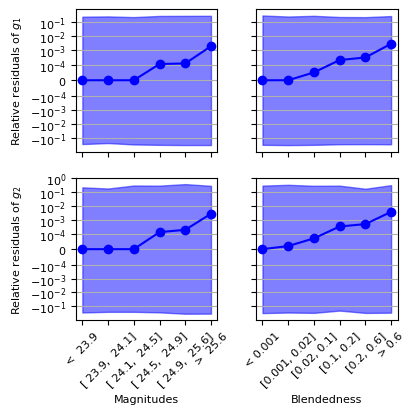

In [63]:
g1g2_fig = ellipticity_plotting.plot()
g1g2_fig.savefig(ellipticity_output_dir / "g1g2.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
g1g2_fig.show()

### Credible Interval

In [64]:
credible_interval_output_dir = output_dir / "credible_interval"
credible_interval_output_dir.mkdir(exist_ok=True)

In [144]:
class CredibleIntervalPlotting:
    def __init__(self, batched_inference_results: BatchedInferenceResults):
        self.locs_sources = 0
        self.locs1_within_ci_num = 0
        self.locs2_within_ci_num = 0
        self.ellipticity_sources = 0
        self.ellipticity1_within_ci_num = 0
        self.ellipticity2_within_ci_num = 0
        self.star_flux_sources = 0
        self.star_flux_within_ci_num = {band: 0 for band in bands}
        self.galaxy_flux_sources = 0
        self.galaxy_flux_within_ci_num = {band: 0 for band in bands}

        bliss_locs_list = []
        bliss_locs_ci_lower_list = []
        bliss_locs_ci_upper_list = []
        locs_mask_list = []
        target_locs_list = []

        for bliss_tile_cat, _lsst_tile_cat, target_tile_cat in batched_inference_results:
            bliss_is_on_mask = bliss_tile_cat.is_on_mask.unsqueeze(-1)
            bliss_m = bliss_is_on_mask.shape[-2]
            target_is_on_mask = target_tile_cat.is_on_mask[..., :bliss_m].unsqueeze(-1)
            both_on_mask = bliss_is_on_mask & target_is_on_mask  # (b, nth, ntw, m, 1)
            self.locs_sources += both_on_mask.sum().item()
            locs_mask_list.append(both_on_mask)
            bliss_locs = bliss_tile_cat["locs"]
            bliss_locs_list.append(bliss_locs)
            bliss_locs_ci_lower = bliss_tile_cat["locs_ci_lower"]  # (b, nth, ntw, m, 2)
            bliss_locs_ci_lower_list.append(bliss_locs_ci_lower)
            bliss_locs_ci_upper = bliss_tile_cat["locs_ci_upper"]
            bliss_locs_ci_upper_list.append(bliss_locs_ci_upper)
            target_locs = target_tile_cat["locs"][..., :bliss_m, :]  # (b, nth, ntw, m, 2)
            target_locs_list.append(target_locs)
            locs_within_ci = (target_locs > bliss_locs_ci_lower) & (target_locs < bliss_locs_ci_upper)  # (b, nth, ntw, m, 2)
            self.locs1_within_ci_num += (locs_within_ci[..., 0:1] & both_on_mask).sum().item()
            self.locs2_within_ci_num += (locs_within_ci[..., 1:2] & both_on_mask).sum().item()

            cosmodc2_mask = target_tile_cat["cosmodc2_mask"][..., :bliss_m, :]
            self.ellipticity_sources += cosmodc2_mask.sum().item()
            ellipticity_mask = both_on_mask & cosmodc2_mask
            bliss_ellipticity_ci_lower = bliss_tile_cat["ellipticity_ci_lower"]  # (b, nth, ntw, m, 2)
            bliss_ellipticity_ci_upper = bliss_tile_cat["ellipticity_ci_upper"]
            target_ellipticity = target_tile_cat["ellipticity"][..., :bliss_m, :]
            ellipticity_within_ci = (target_ellipticity > bliss_ellipticity_ci_lower) & (target_ellipticity < bliss_ellipticity_ci_upper)
            self.ellipticity1_within_ci_num += (ellipticity_within_ci[..., 0:1] & ellipticity_mask).sum().item()
            self.ellipticity2_within_ci_num += (ellipticity_within_ci[..., 1:2] & ellipticity_mask).sum().item()

            star_mask = bliss_tile_cat.star_bools & target_tile_cat.star_bools[..., :bliss_m, :]
            self.star_flux_sources += star_mask.sum().item()
            bliss_star_flux_ci_lower = bliss_tile_cat["star_fluxes_ci_lower"]
            bliss_star_flux_ci_upper = bliss_tile_cat["star_fluxes_ci_upper"]
            target_star_flux = target_tile_cat["star_fluxes"][..., :bliss_m, :]
            star_flux_within_ci = (target_star_flux > bliss_star_flux_ci_lower) & (target_star_flux < bliss_star_flux_ci_upper)
            for i, band in enumerate(bands):
                self.star_flux_within_ci_num[band] += (star_flux_within_ci[..., i:(i + 1)] & star_mask).sum().item()

            galaxy_mask = bliss_tile_cat.galaxy_bools & target_tile_cat.galaxy_bools[..., :bliss_m, :]
            self.galaxy_flux_sources += galaxy_mask.sum().item()
            bliss_galaxy_flux_ci_lower = bliss_tile_cat["galaxy_fluxes_ci_lower"]
            bliss_galaxy_flux_ci_upper = bliss_tile_cat["galaxy_fluxes_ci_upper"]
            target_galaxy_flux = target_tile_cat["galaxy_fluxes"][..., :bliss_m, :]
            galaxy_flux_within_ci = (target_galaxy_flux > bliss_galaxy_flux_ci_lower) & (target_galaxy_flux < bliss_galaxy_flux_ci_upper)
            for i, band in enumerate(bands):
                self.galaxy_flux_within_ci_num[band] += (galaxy_flux_within_ci[..., i:(i + 1)] & galaxy_mask).sum().item()

        rand_int = random.randint(0, len(bliss_locs_list) - 1)
        bliss_locs = bliss_locs_list[rand_int]
        bliss_locs_ci_lower = bliss_locs_ci_lower_list[rand_int]
        bliss_locs_ci_upper = bliss_locs_ci_upper_list[rand_int]
        target_locs = target_locs_list[rand_int]
        locs_mask = locs_mask_list[rand_int]

        self.bliss_locs1 = bliss_locs[..., 0].flatten()[locs_mask.flatten()]
        self.bliss_locs1_ci_lower = bliss_locs_ci_lower[..., 0].flatten()[locs_mask.flatten()]
        self.bliss_locs1_ci_upper = bliss_locs_ci_upper[..., 0].flatten()[locs_mask.flatten()]
        self.target_locs1 = target_locs[..., 0].flatten()[locs_mask.flatten()]

        self.bliss_locs2 = bliss_locs[..., 1].flatten()[locs_mask.flatten()]
        self.bliss_locs2_ci_lower = bliss_locs_ci_lower[..., 1].flatten()[locs_mask.flatten()]
        self.bliss_locs2_ci_upper = bliss_locs_ci_upper[..., 1].flatten()[locs_mask.flatten()]
        self.target_locs2 = target_locs[..., 1].flatten()[locs_mask.flatten()]

    def report(self):
        print(f"# locs sources: {self.locs_sources}")
        print(f"# locs1 within ci: {self.locs1_within_ci_num}")
        print(f"locs1 within ci: {self.locs1_within_ci_num / self.locs_sources: .4f}")
        print(f"# locs2 within ci: {self.locs2_within_ci_num}")
        print(f"locs2 within ci: {self.locs2_within_ci_num / self.locs_sources: .4f}")
        print()
        print(f"# ellipticity sources: {self.ellipticity_sources}")
        print(f"# ellipticity1 within ci: {self.ellipticity1_within_ci_num}")
        print(f"ellipticity1 within ci: {self.ellipticity1_within_ci_num / self.ellipticity_sources: .4f}")
        print(f"# ellipticity2 within ci: {self.ellipticity2_within_ci_num}")
        print(f"ellipticity2 within ci: {self.ellipticity2_within_ci_num / self.ellipticity_sources: .4f}")
        print()
        print(f"# star sources: {self.star_flux_sources}")
        for band in bands:
            print(f"# {band} flux within ci: {self.star_flux_within_ci_num[band]}")
            print(f"{band} flux within ci: {self.star_flux_within_ci_num[band] / self.star_flux_sources: .4f}")
        print()
        print(f"# galaxy sources: {self.galaxy_flux_sources}")
        for band in bands:
            print(f"# {band} flux within ci: {self.galaxy_flux_within_ci_num[band]}")
            print(f"{band} flux within ci: {self.galaxy_flux_within_ci_num[band] / self.galaxy_flux_sources: .4f}")

    def plot(self):
        fig1, ax1 = plt.subplots(1, 1, figsize=NoteBookPlottingParams.figsize)

        locs1_err = (torch.stack((self.bliss_locs1_ci_lower, self.bliss_locs1_ci_upper), dim=0) - self.bliss_locs1.unsqueeze(0)).abs()
        ax1.errorbar(x=self.target_locs1, y=self.bliss_locs1, yerr=locs1_err, fmt="none")
        x = [0, 1]
        y = [0, 1]
        ax1.plot(x, y, color="red")
        ax1.set_ylabel("Estimated $locs_1$", fontsize=NoteBookPlottingParams.fontsize)
        ax1.set_xlabel("True Vertical Position", fontsize=NoteBookPlottingParams.fontsize)
        ax1.tick_params(labelsize=NoteBookPlottingParams.fontsize)

        fig1.tight_layout()

        fig2, ax2 = plt.subplots(1, 1, figsize=NoteBookPlottingParams.figsize)

        locs2_err = (torch.stack((self.bliss_locs2_ci_lower, self.bliss_locs2_ci_upper), dim=0) - self.bliss_locs2.unsqueeze(0)).abs()
        ax2.errorbar(x=self.target_locs2, y=self.bliss_locs2, yerr=locs2_err, fmt="none")
        x = [0, 1]
        y = [0, 1]
        ax2.plot(x, y, color="red")
        ax2.set_ylabel("Estimated $locs_2$", fontsize=NoteBookPlottingParams.fontsize)
        ax2.set_xlabel("True Horizontal Position", fontsize=NoteBookPlottingParams.fontsize)
        ax2.tick_params(labelsize=NoteBookPlottingParams.fontsize)

        fig2.tight_layout()

        return fig1, fig2

In [145]:
def get_credible_interval_plotting():
    return CredibleIntervalPlotting(batched_inference_results)

In [146]:
credible_interval_plotting = get_credible_interval_plotting()

In [68]:
credible_interval_plotting.report()

# locs sources: 126934
# locs1 within ci: 119439
locs1 within ci:  0.9410
# locs2 within ci: 119232
locs2 within ci:  0.9393

# ellipticity sources: 128439
# ellipticity1 within ci: 93419
ellipticity1 within ci:  0.7273
# ellipticity2 within ci: 93393
ellipticity2 within ci:  0.7271

# star sources: 3648
# u flux within ci: 3271
u flux within ci:  0.8967
# g flux within ci: 3486
g flux within ci:  0.9556
# r flux within ci: 3524
r flux within ci:  0.9660
# i flux within ci: 3571
i flux within ci:  0.9789
# z flux within ci: 3555
z flux within ci:  0.9745
# y flux within ci: 3536
y flux within ci:  0.9693

# galaxy sources: 122431
# u flux within ci: 112494
u flux within ci:  0.9188
# g flux within ci: 111544
g flux within ci:  0.9111
# r flux within ci: 111946
r flux within ci:  0.9144
# i flux within ci: 111833
i flux within ci:  0.9134
# z flux within ci: 111855
z flux within ci:  0.9136
# y flux within ci: 111311
y flux within ci:  0.9092


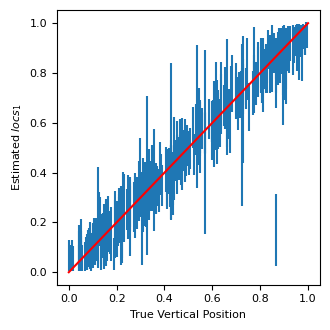

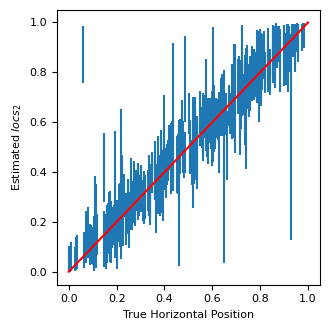

In [147]:
fig1, fig2 = credible_interval_plotting.plot()
fig1.savefig(credible_interval_output_dir / "locs1_ci.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig1.show()
fig2.savefig(credible_interval_output_dir / "locs2_ci.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig2.show()

### VSBC

In [70]:
vsbc_output_dir = output_dir / "vsbc"
vsbc_output_dir.mkdir(exist_ok=True)

In [152]:
class VSBCPlotting:
    def __init__(self, batched_inference_results: BatchedInferenceResults):
        ellipticity1_vsbc_list = []
        ellipticity2_vsbc_list = []
        locs1_vsbc_list = []
        locs2_vsbc_list = []
        self.star_flux_vsbc_dict = {band: [] for band in bands}
        self.galaxy_flux_vsbc_dict = {band: [] for band in bands}
        is_on_mask_list = []
        for bliss_tile_cat, _lsst_tile_cat, _target_tile_cat in batched_inference_results:
            ellipticity_vsbc = bliss_tile_cat["ellipticity_vsbc"]
            ellipticity1_vsbc_list.append(ellipticity_vsbc[..., 0])
            ellipticity2_vsbc_list.append(ellipticity_vsbc[..., 1])
            is_on_mask_list.append(bliss_tile_cat.is_on_mask)

            locs_vsbc = bliss_tile_cat["locs_vsbc"]
            locs1_vsbc_list.append(locs_vsbc[..., 0])
            locs2_vsbc_list.append(locs_vsbc[..., 1])
            
            star_flux_vsbc = bliss_tile_cat["star_fluxes_vsbc"]
            galaxy_flux_vsbc = bliss_tile_cat["galaxy_fluxes_vsbc"]
            for i, band in enumerate(bands):
                self.star_flux_vsbc_dict[band].append(star_flux_vsbc[..., i])
                self.galaxy_flux_vsbc_dict[band].append(galaxy_flux_vsbc[..., i])

        self.ellipticity1_vsbc = torch.cat(ellipticity1_vsbc_list, dim=0).flatten()
        self.ellipticity2_vsbc = torch.cat(ellipticity2_vsbc_list, dim=0).flatten()
        self.locs1_vsbc = torch.cat(locs1_vsbc_list, dim=0).flatten()
        self.locs2_vsbc = torch.cat(locs2_vsbc_list, dim=0).flatten()
        self.is_on_mask = torch.cat(is_on_mask_list, dim=0).flatten()

        for k, v in self.star_flux_vsbc_dict.items():
            self.star_flux_vsbc_dict[k] = torch.cat(v, dim=0).flatten()

        for k, v in self.galaxy_flux_vsbc_dict.items():
            self.galaxy_flux_vsbc_dict[k] = torch.cat(v, dim=0).flatten()

    def _ellipticity_plot(self):
        fig1, ax1 = plt.subplots(1, 1, figsize=(NoteBookPlottingParams.figsize[0] * 0.5, NoteBookPlottingParams.figsize[1] * 0.5))

        ax1.hist(self.ellipticity1_vsbc[self.is_on_mask & ~self.ellipticity1_vsbc.isnan()], density=True, bins=50)
        ax1.axvline(0.5, color="red")
        ax1.set_ylabel("Density", fontsize=NoteBookPlottingParams.fontsize)
        ax1.set_xlabel("$P_{g_1}$", fontsize=NoteBookPlottingParams.fontsize)
        ax1.set_xticks(np.linspace(0.0, 1.0, num=3))
        ax1.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=3)])
        ax1.tick_params(labelsize=NoteBookPlottingParams.fontsize)

        fig1.tight_layout()

        fig2, ax2 = plt.subplots(1, 1, figsize=(NoteBookPlottingParams.figsize[0] * 0.5, NoteBookPlottingParams.figsize[1] * 0.5))

        ax2.hist(self.ellipticity2_vsbc[self.is_on_mask & ~self.ellipticity2_vsbc.isnan()], density=True, bins=50)
        ax2.axvline(0.5, color="red")
        ax2.set_ylabel("Density", fontsize=NoteBookPlottingParams.fontsize)
        ax2.set_xlabel("$P_{g_2}$", fontsize=NoteBookPlottingParams.fontsize)
        ax2.set_xticks(np.linspace(0.0, 1.0, num=3))
        ax2.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=3)])
        ax2.tick_params(labelsize=NoteBookPlottingParams.fontsize)

        fig2.tight_layout()
        
        return fig1, fig2
    
    def _locs_plot(self):
        fig1, ax1 = plt.subplots(1, 1, figsize=(NoteBookPlottingParams.figsize[0] * 0.5, NoteBookPlottingParams.figsize[1] * 0.5))

        ax1.hist(self.locs1_vsbc[self.is_on_mask & ~self.locs1_vsbc.isnan()], density=True, bins=50)
        ax1.axvline(0.5, color="red")
        ax1.set_ylabel("Density", fontsize=NoteBookPlottingParams.fontsize)
        ax1.set_xlabel("$P_{locs_1}$", fontsize=NoteBookPlottingParams.fontsize)
        ax1.set_xticks(np.linspace(0.0, 1.0, num=3))
        ax1.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=3)])
        ax1.tick_params(labelsize=NoteBookPlottingParams.fontsize)

        fig1.tight_layout()
        
        fig2, ax2 = plt.subplots(1, 1, figsize=(NoteBookPlottingParams.figsize[0] * 0.5, NoteBookPlottingParams.figsize[1] * 0.5))

        ax2.hist(self.locs2_vsbc[self.is_on_mask & ~self.locs2_vsbc.isnan()], density=True, bins=50)
        ax2.axvline(0.5, color="red")
        ax2.set_ylabel("Density", fontsize=NoteBookPlottingParams.fontsize)
        ax2.set_xlabel("$P_{locs_2}$", fontsize=NoteBookPlottingParams.fontsize)
        ax2.set_xticks(np.linspace(0.0, 1.0, num=3))
        ax2.set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=3)])
        ax2.tick_params(labelsize=NoteBookPlottingParams.fontsize)

        fig2.tight_layout()

        return fig1, fig2
    
    def _star_flux_plot(self):
        fig, axes = plt.subplots(3, 2, 
                         figsize=(NoteBookPlottingParams.figsize[0] * 1.1, NoteBookPlottingParams.figsize[1] * 1.7), 
                         sharex="col", 
                         sharey="row",
                         layout="constrained")

        for i, band in enumerate(bands):
            col_index = i % 2
            row_index = i // 2
            ax = axes[row_index, col_index]
            star_flux_vsbc = self.star_flux_vsbc_dict[band]
            star_flux_vsbc = star_flux_vsbc[self.is_on_mask & ~star_flux_vsbc.isnan()]
            ax.hist(star_flux_vsbc, density=True, bins=50)
            ax.axvline(0.5, color="red")
            ax.set_title(f"{band} band", fontsize=NoteBookPlottingParams.fontsize)
            ax.grid(visible=False)

        axes[1, 0].set_ylabel("Density", fontsize=NoteBookPlottingParams.fontsize)
        axes[2, 0].set_xticks(np.linspace(0.0, 1.0, num=6))
        axes[2, 0].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=6)])
        axes[2, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[2, 0].set_xlabel("$P_{star\ flux}$", fontsize=NoteBookPlottingParams.fontsize)
        axes[2, 1].set_xticks(np.linspace(0.0, 1.0, num=6))
        axes[2, 1].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=6)])
        axes[2, 1].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[2, 1].set_xlabel("$P_{star\ flux}$", fontsize=NoteBookPlottingParams.fontsize)

        axes[0, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[1, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[2, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)

        return fig
    
    def _galaxy_flux_plot(self):
        fig, axes = plt.subplots(3, 2, 
                         figsize=(NoteBookPlottingParams.figsize[0] * 1.1, NoteBookPlottingParams.figsize[1] * 1.7), 
                         sharex="col", 
                         sharey="row",
                         layout="constrained")

        for i, band in enumerate(bands):
            col_index = i % 2
            row_index = i // 2
            ax = axes[row_index, col_index]
            galaxy_flux_vsbc = self.galaxy_flux_vsbc_dict[band]
            galaxy_flux_vsbc = galaxy_flux_vsbc[self.is_on_mask & ~galaxy_flux_vsbc.isnan()]
            ax.hist(galaxy_flux_vsbc, density=True, bins=50)
            ax.axvline(0.5, color="red")
            ax.set_title(f"{band} band", fontsize=NoteBookPlottingParams.fontsize)
            ax.grid(visible=False)

        axes[1, 0].set_ylabel("Density", fontsize=NoteBookPlottingParams.fontsize)
        axes[2, 0].set_xticks(np.linspace(0.0, 1.0, num=6))
        axes[2, 0].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=6)])
        axes[2, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[2, 0].set_xlabel("$P_{galaxy\ flux}$", fontsize=NoteBookPlottingParams.fontsize)
        axes[2, 1].set_xticks(np.linspace(0.0, 1.0, num=6))
        axes[2, 1].set_xticklabels([f"{i: .1f}" for i in np.linspace(0.0, 1.0, num=6)])
        axes[2, 1].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[2, 1].set_xlabel("$P_{galaxy\ flux}$", fontsize=NoteBookPlottingParams.fontsize)

        axes[0, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[1, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)
        axes[2, 0].tick_params(labelsize=NoteBookPlottingParams.fontsize * 0.7)

        return fig

    def plot(self, plot_type: str):
        match plot_type:
            case "ellipticity":
                return self._ellipticity_plot()
            case "locs":
                return self._locs_plot()
            case "star_flux":
                return self._star_flux_plot()
            case "galaxy_flux":
                return self._galaxy_flux_plot()
            case _:
                raise NotImplementedError()

In [153]:
def get_vsbc_plotting():
    return VSBCPlotting(batched_inference_results)

In [154]:
vsbc_plotting = get_vsbc_plotting()

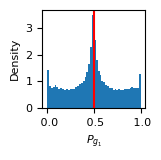

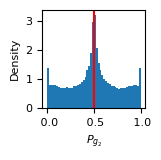

In [138]:
fig1, fig2 = vsbc_plotting.plot("ellipticity")
fig1.savefig(vsbc_output_dir / "g1_vsbc.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig1.show()
fig2.savefig(vsbc_output_dir / "g2_vsbc.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig2.show()

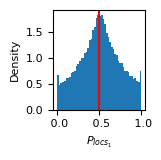

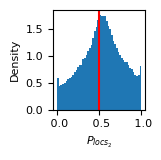

In [139]:
fig1, fig2 = vsbc_plotting.plot("locs")
fig1.savefig(vsbc_output_dir / "locs1_vsbc.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig1.show()
fig2.savefig(vsbc_output_dir / "locs2_vsbc.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig2.show()

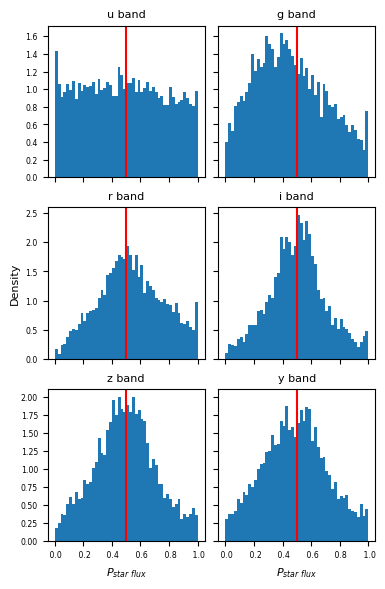

In [155]:
fig = vsbc_plotting.plot("star_flux")
fig.savefig(vsbc_output_dir / "star_flux_vsbc.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()

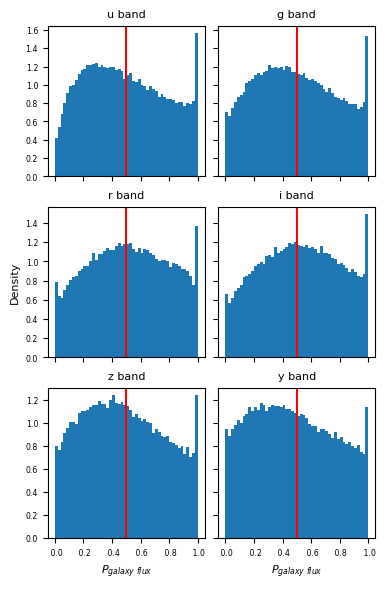

In [156]:
fig = vsbc_plotting.plot("galaxy_flux")
fig.savefig(vsbc_output_dir / "galaxy_flux_vsbc.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()

### Boundary Performance

In [78]:
boundary_performance_output_dir = output_dir / "boundary_performance"
boundary_performance_output_dir.mkdir(exist_ok=True)

In [79]:
class BoundaryPerformancePlotting:
    def __init__(self,
                 bliss_metric_results,
                 lsst_metric_results,
                 bin_cutoffs):
        self.bliss_metric_results = bliss_metric_results
        self.lsst_metric_results = lsst_metric_results
        self.xlabels = (
            [f"< {bin_cutoffs[0]: .1f}"]
            + [f"[{bin_cutoffs[i]: .1f}, {bin_cutoffs[i + 1]: .1f}]" for i in range(len(bin_cutoffs) - 1)]
            + [f"> {bin_cutoffs[-1]: .1f}"]
        )

    def _plot(self, postfix_str):
        fig, ax = plt.subplots(1, 1, figsize=NoteBookPlottingParams.figsize)
    
        graph_tag = f"({postfix_str[1:]})".replace("_", " ") if postfix_str else ""

        x = list(range(len(self.xlabels)))

        bliss_recall = self.bliss_metric_results[f"detection_recall{postfix_str}"]
        bliss_precision = self.bliss_metric_results[f"detection_precision{postfix_str}"]
        bliss_f1 = self.bliss_metric_results[f"detection_f1{postfix_str}"]
        
        lsst_recall = self.lsst_metric_results[f"detection_recall{postfix_str}"]
        lsst_precision = self.lsst_metric_results[f"detection_precision{postfix_str}"]
        lsst_f1 = self.lsst_metric_results[f"detection_f1{postfix_str}"]

        ax.plot(
            x,
            bliss_recall,
            color=NoteBookPlottingParams.color_dict["bliss"],
            linestyle="solid",
            label=f"BLISS Recall {graph_tag}",
        )
        ax.plot(
            x,
            bliss_precision,
            color=NoteBookPlottingParams.color_dict["bliss"],
            linestyle="dotted",
            label=f"BLISS Precision {graph_tag}",
        )
        ax.plot(
            x,
            bliss_f1,
            color=NoteBookPlottingParams.color_dict["bliss"],
            linestyle="dashdot",
            label=f"BLISS F1 {graph_tag}",
        )

        ax.plot(
            x,
            lsst_recall,
            color=NoteBookPlottingParams.color_dict["lsst"],
            linestyle="solid",
            label=f"LSST Recall {graph_tag}",
        )
        ax.plot(
            x,
            lsst_precision,
            color=NoteBookPlottingParams.color_dict["lsst"],
            linestyle="dotted",
            label=f"LSST Precision {graph_tag}",
        )
        ax.plot(
            x,
            lsst_f1,
            color=NoteBookPlottingParams.color_dict["lsst"],
            linestyle="dashdot",
            label=f"LSST F1 {graph_tag}",
        )
    
        ax.set_xlabel("Magnitudes", fontsize=NoteBookPlottingParams.fontsize)
        ax.set_xticks(x)
        ax.set_xticklabels(self.xlabels, rotation=45)
        ax.set_ylabel("Value", fontsize=NoteBookPlottingParams.fontsize)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.legend(fontsize=NoteBookPlottingParams.fontsize)
    
        fig.tight_layout()

        return fig
    
    def plot(self, plot_type):
        match plot_type:
            case "in_boundary":
                return self._plot(postfix_str="_in_boundary")
            case "out_boundary":
                return self._plot(postfix_str="_out_boundary")
            case "star_in_boundary":
                return self._plot(postfix_str="_star_in_boundary")
            case "star_out_boundary":
                return self._plot(postfix_str="_star_out_boundary")
            case "galaxy_in_boundary":
                return self._plot(postfix_str="_galaxy_in_boundary")
            case "galaxy_out_boundary":
                return self._plot(postfix_str="_galaxy_out_boundary")
            case _:
                raise NotImplementedError()

In [80]:
def get_boundary_performance_plotting():
    bliss_metrics = MetricCollection({
        "detection_performance_in_boundary": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                                  mag_zero_point=mag_zero_point,
                                                                  report_bin_unit="mag",
                                                                  filter_list=[InBoundaryFilter(tile_slen=tile_slen, 
                                                                                                boundary_width=boundary_width)]),
        "detection_performance_out_boundary": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                                   mag_zero_point=mag_zero_point,
                                                                   report_bin_unit="mag",
                                                                   filter_list=[OutBoundaryFilter(tile_slen=tile_slen, 
                                                                                                  boundary_width=boundary_width)]),
        "detection_performance_star_in_boundary": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                                       mag_zero_point=mag_zero_point,
                                                                       report_bin_unit="mag",
                                                                       filter_list=[SourceTypeFilter(filter_type="star"),
                                                                                    InBoundaryFilter(tile_slen=tile_slen, 
                                                                                                     boundary_width=boundary_width)]),
        "detection_performance_star_out_boundary": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                                        mag_zero_point=mag_zero_point,
                                                                        report_bin_unit="mag",
                                                                        filter_list=[SourceTypeFilter(filter_type="star"),
                                                                                     OutBoundaryFilter(tile_slen=tile_slen, 
                                                                                                       boundary_width=boundary_width)]),
        "detection_performance_galaxy_in_boundary": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                                         mag_zero_point=mag_zero_point,
                                                                         report_bin_unit="mag",
                                                                         filter_list=[SourceTypeFilter(filter_type="galaxy"),
                                                                                      InBoundaryFilter(tile_slen=tile_slen, 
                                                                                                       boundary_width=boundary_width)]),
        "detection_performance_galaxy_out_boundary": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                                          mag_zero_point=mag_zero_point,
                                                                          report_bin_unit="mag",
                                                                          filter_list=[SourceTypeFilter(filter_type="galaxy"),
                                                                                       OutBoundaryFilter(tile_slen=tile_slen, 
                                                                                                         boundary_width=boundary_width)]),
    })
    lsst_metrics = bliss_metrics.clone()

    bliss_metric_results = {}
    lsst_metric_results = {}

    bliss_matching = matcher.match_catalogs(test_4000x4000_results.test_image_full_cat, 
                                            test_4000x4000_results.bliss_full_cat)
    bliss_metrics.update(test_4000x4000_results.test_image_full_cat, 
                         test_4000x4000_results.bliss_full_cat,
                           bliss_matching)

    lsst_matching = matcher.match_catalogs(test_4000x4000_results.test_image_full_cat, 
                                           test_4000x4000_results.lsst_full_cat)
    lsst_metrics.update(test_4000x4000_results.test_image_full_cat, 
                        test_4000x4000_results.lsst_full_cat, 
                        lsst_matching)

    for k, v in bliss_metrics.items():
        results = v.get_results_on_per_bin()
        for k_results, v_results in results.items():
            bliss_metric_results[k_results] = v_results

    for k, v in lsst_metrics.items():
        results = v.get_results_on_per_bin()
        for k_results, v_results in results.items():
            lsst_metric_results[k_results] = v_results

    return BoundaryPerformancePlotting(bliss_metric_results,
                                       lsst_metric_results,
                                       bliss_metrics["detection_performance_in_boundary"].get_report_bins())

In [81]:
boundary_performance_plotting = get_boundary_performance_plotting()

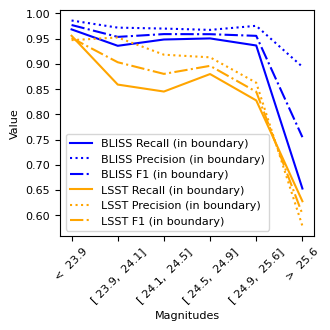

In [82]:
fig = boundary_performance_plotting.plot("in_boundary")
fig.savefig(boundary_performance_output_dir / "in_boundary.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()

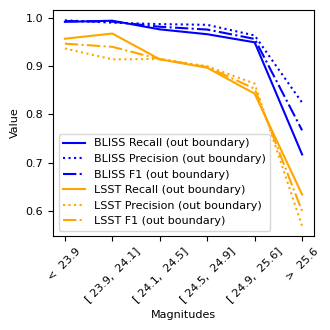

In [83]:
fig = boundary_performance_plotting.plot("out_boundary")
fig.savefig(boundary_performance_output_dir / "out_boundary.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()

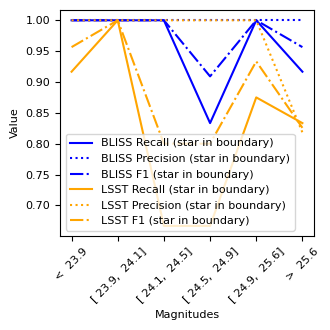

In [84]:
fig = boundary_performance_plotting.plot("star_in_boundary")
fig.savefig(boundary_performance_output_dir / "star_in_boundary.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()

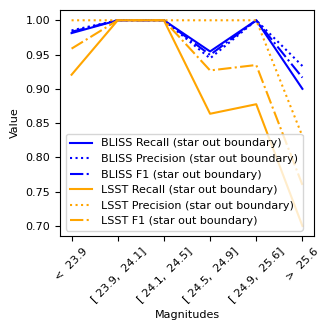

In [85]:
fig = boundary_performance_plotting.plot("star_out_boundary")
fig.savefig(boundary_performance_output_dir / "star_out_boundary.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()

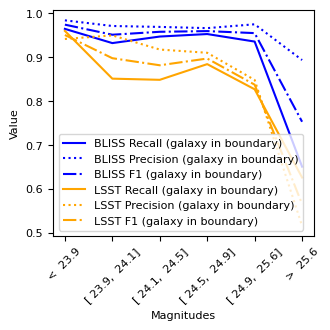

In [86]:
fig = boundary_performance_plotting.plot("galaxy_in_boundary")
fig.savefig(boundary_performance_output_dir / "galaxy_in_boundary.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()

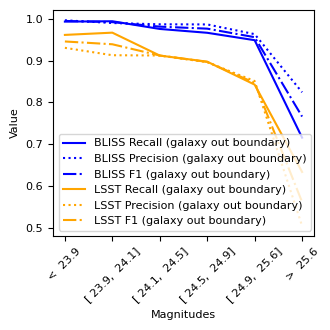

In [87]:
fig = boundary_performance_plotting.plot("galaxy_out_boundary")
fig.savefig(boundary_performance_output_dir / "galaxy_out_boundary.pdf", bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()